# **Spotify Analysis**: Master Data Prep & Exploration


---

**Data**: My dataset spans from April 2016 to August 2024, extracted via Exportify from my seasonal Spotify playlists. Each entry contains rich metadata including artist, track, addition date, and genre.

**Motivation & Hypothesis**: This dataset captures a transformative period in my life. From relocating from Dubai to Indiana for college in , navigating the global pandemic (and graduate school in lockdown), experiencing personal losses, moving to San Francisco, starting my career, meeting my now husband and getting married, and transitioning between jobs. Throughout these experiences, Spotify remained a constant companion.

I've observed that my playlists often serve as a form of musical journaling, reflecting my emotional state and circumstances. This project aims to analyze the evolution of my musical preferences over time and explore potential correlations between playlist characteristics (content, length, addition frequency) and my emotional well-being.

Key focus areas include:

1. Temporal analysis of musical taste to confirm if the data reveals what I think know about my music taste or if it suprises me 
2. Seasonal patterns in playlist composition, particularly in relation to weather changes in West Lafayette, IN and San Francisco
3. Sentiment analysis of song lyrics, with a specific focus on the period of July 2023 to present (coinciding with my period of unemployment)

By examining these data points, I hope to uncover insights into how my music choices have mirrored my life experiences and emotional states during this pivotal time. 

###### **It is important to note that this data did not include how often I listened to specific songs, just when I added them to a given playlist.**
---


In [80]:
#Install all relevant packages: 
%run pip_installs.py
%run packages.py

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/varshis./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/varshis./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/varshis./nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/varshis./nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/varshis./nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/varshis./nltk_data...
[nltk_data]    |   Package

### Importing my data and correcting datetime datatypes 
#### I am creating a dictionary for all my individual playlists in case I want to do deeper dives for future stages of this project

In [81]:
import pandas as pd
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def read_csv_safely(file_path):
    try:
        df = pd.read_csv(file_path)
    except pd.errors.ParserError:
        logging.warning(f"Parser error encountered for {file_path}. Attempting to read with 'python' engine.")
        df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
    except Exception as e:
        logging.error(f"Error reading {file_path}: {str(e)}")
        return None
    
    # Convert the 'Added At' column to datetime with UTC
    if 'Added At' in df.columns:
        df['Added At'] = pd.to_datetime(df['Added At'], utc=True, errors='coerce')
    
    # Convert the 'Release Date' column to datetime, handling various formats
    if 'Release Date' in df.columns:
        df['Release Date'] = pd.to_datetime(df['Release Date'], format='mixed', errors='coerce')
    
    return df

def process_file(file_path, data_dir):
    filename = os.path.basename(file_path)
    df_name = os.path.splitext(filename)[0]
    df = read_csv_safely(file_path)
    if df is not None:
        df['Playlist'] = df_name  # Add 'playlist' column with the dataframe name
        logging.info(f"Processed '{df_name}' shape: {df.shape}")
        return df_name, df
    return None

# Defining seasons as such: March-May is Spring, June-August is Summer, September-November is Fall, December-February is Winter
def get_season_udf(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

def main():
    # Define the directory containing the CSV files
    data_dir = 'raw_csv'

    # Get all CSV filenames from the directory
    filenames = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

    # Dictionary to store dataframes
    dataframes = {}

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, os.path.join(data_dir, filename), data_dir) for filename in filenames]
        
        for future in as_completed(futures):
            result = future.result()
            if result:
                df_name, df = result
                dataframes[df_name] = df

    # Create a master dataframe concatenating all the individual dataframes
    master_df = pd.concat(dataframes.values(), ignore_index=True)

    # Apply the function to create a new 'Season' column
    master_df['Season'] = master_df['Added At'].apply(get_season_udf)

    logging.info(f"Master dataframe shape: {master_df.shape}")

    return master_df

if __name__ == "__main__":
    master_df = main()

2024-08-29 16:17:42,654 - WARNING - Parser error encountered for raw_csv/clean.csv. Attempting to read with 'python' engine.
2024-08-29 16:17:42,655 - WARNING - Parser error encountered for raw_csv/fs19.csv. Attempting to read with 'python' engine.
2024-08-29 16:17:42,663 - INFO - Processed 'wildcats' shape: (45, 24)
2024-08-29 16:17:42,668 - INFO - Processed 'sb19' shape: (75, 24)
2024-08-29 16:17:42,669 - INFO - Processed 'wb23' shape: (30, 24)
2024-08-29 16:17:42,679 - INFO - Processed 'fs24' shape: (9, 24)
2024-08-29 16:17:42,696 - INFO - Processed 'm_a_t_s_a_m_u_k_i___p_l_a_y_h_o_u_s_e' shape: (570, 24)
2024-08-29 16:17:42,699 - INFO - Processed 'breakfast' shape: (145, 24)
2024-08-29 16:17:42,700 - INFO - Processed 'r_l_x' shape: (158, 24)
2024-08-29 16:17:42,703 - INFO - Processed 'fs18' shape: (355, 24)
2024-08-29 16:17:42,708 - INFO - Processed 'escape' shape: (585, 24)
2024-08-29 16:17:42,713 - INFO - Processed 'fs19' shape: (330, 24)
2024-08-29 16:17:42,714 - INFO - Processe

In [82]:
# Define the output directory
output_dir = 'processed_csv'

# Define the filenames for the CSV files
master_df_filename = 'master_df.csv'

# Create the full paths to the output CSV files
master_df_path = os.path.join(output_dir, master_df_filename)

# Save the DataFrames as CSV files
master_df.to_csv(master_df_path, index=False)

### Adding a 'Season' column for visualizations later on in this analysis

In [83]:
master_df

,Spotify ID,Artist IDs,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,...,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Season
0,0cqNGWvuukhCiKvEX7utys,"2gUMs9PE8XZVQyzCDqaYmW,3xvaSlT4xsyk6lY1ESOspO",We're All In This Together,High School Musical,"High School Musical Cast,Disney",2006-01-01,231426,64,spotify:user:vrshi,2017-02-23 09:24:17+00:00,...,1.00,0.07,0.05,0.00,0.65,0.81,116.01,4.00,wildcats,Winter
1,5zQ1Wq6HNYjGZWkVv5P8Eg,"6zTbBugfNc95zo8ClFDhIn,0GyAZiIV45rnBBf4KdGLS7,...",Breaking Free,High School Musical,"Troy,Gabriella,Disney",2006-01-01,207200,59,spotify:user:vrshi,2017-02-23 09:24:41+00:00,...,0.00,0.04,0.05,0.00,0.13,0.33,107.94,4.00,wildcats,Winter
2,4gqjxYiEorFk0y9b92uFdE,"4Ee4pZJB0SAQwfKqb31mem,3WtcOzeKXq5mUINE0bNfnt,...",Bop To The Top,High School Musical,"Ryan,Sharpay Evans,High School Musical Cast,Di...",2006-01-01,107826,56,spotify:user:vrshi,2017-02-23 09:24:45+00:00,...,0.00,0.07,0.35,0.00,0.04,0.93,112.16,4.00,wildcats,Winter
3,1LxcCsgkHJTcUZ7AUorzd2,"6G9bygHlCyPgNGxK2l3YdE,3xvaSlT4xsyk6lY1ESOspO",When There Was Me and You,High School Musical,"Vanessa Hudgens,Disney",2006-01-01,180440,54,spotify:user:vrshi,2017-02-23 09:25:02+00:00,...,1.00,0.04,0.04,0.00,0.11,0.26,119.93,4.00,wildcats,Winter
4,5aNagthlHAudbDZozQMjYP,"2gUMs9PE8XZVQyzCDqaYmW,3xvaSlT4xsyk6lY1ESOspO",Stick to the Status Quo,High School Musical,"High School Musical Cast,Disney",2006-01-01,268413,56,spotify:user:vrshi,2017-02-23 09:25:06+00:00,...,1.00,0.19,0.03,0.00,0.25,0.82,159.98,4.00,wildcats,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10604,2KYnSFIrSbaKUXWetW7Klt,"4CA8PTrbq1l5IgyvBA2JSV,5fMUXHkw8R8eOP2RNVYEZX,...",Looking For Me,Do You Dance?,"Paul Woolford,Diplo,Kareen Lomax",2021-03-12,211452,62,spotify:user:vrshi,2024-06-03 17:43:17+00:00,...,1.00,0.03,0.00,0.00,0.08,0.45,121.03,4.00,all_time_,Summer
10605,1VhD0FPDYqFhqRJVguVAJe,"3CYrfsHEf7AZRlKUvzTnpA,3bUHVz55uXLTtxggKQyXIO,...",Something Stronger,Something Stronger,"Rules,SHYA,Coldabank",2023-03-17,127530,71,spotify:user:vrshi,2024-06-03 17:43:34+00:00,...,0.00,0.03,0.04,0.00,0.09,0.21,124.03,4.00,all_time_,Summer
10606,0sftzYE0YgPHXrvJyUyGjB,"0NGAZxHanS9e0iNHpR8f2W,64M6ah0SkkRsnPGtGiRAbb",Deep In Your Love,Deep In Your Love,"Alok,Bebe Rexha",2024-01-12,144648,73,spotify:user:vrshi,2024-06-03 17:43:42+00:00,...,1.00,0.04,0.02,0.00,0.07,0.52,130.09,4.00,all_time_,Summer
10607,0KG7XrgM20KEmJrKsyFDAm,"5fMUXHkw8R8eOP2RNVYEZX,2kLa7JZu4Ijdz1Gle2khZh,...",Let You Go,Diplo,"Diplo,TSHA,Kareen Lomax",2022-03-04,234374,51,spotify:user:vrshi,2024-06-03 17:44:38+00:00,...,0.00,0.05,0.10,0.00,0.09,0.49,128.04,4.00,all_time_,Summer


### Creating a subset dataframe with columns I am interested in (for now)

In [84]:
df_subset = master_df[['Track Name', 'Album Name',
       'Artist Name(s)', 'Release Date', 'Duration (ms)','Added At', 'Genres', 'Valence','Danceability', 'Energy',
       'Tempo','Playlist', 'Season']]

In [85]:
df_subset.head(3)

,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Added At,Genres,Valence,Danceability,Energy,Tempo,Playlist,Season
0,We're All In This Together,High School Musical,"High School Musical Cast,Disney",2006-01-01,231426,2017-02-23 09:24:17+00:00,"movie tunes,post-teen pop",0.81,0.76,0.94,116.01,wildcats,Winter
1,Breaking Free,High School Musical,"Troy,Gabriella,Disney",2006-01-01,207200,2017-02-23 09:24:41+00:00,movie tunes,0.33,0.58,0.59,107.94,wildcats,Winter
2,Bop To The Top,High School Musical,"Ryan,Sharpay Evans,High School Musical Cast,Di...",2006-01-01,107826,2017-02-23 09:24:45+00:00,"movie tunes,west end,post-teen pop",0.93,0.60,0.81,112.16,wildcats,Winter


In [86]:
df_subset.describe()

,Release Date,Duration (ms),Valence,Danceability,Energy,Tempo
count,10556,10609.00,10576.00,10576.00,10576.00,10576.00
mean,2016-12-15 15:16:18.097764352,209230.35,0.46,0.65,0.68,121.88
min,1948-01-01 00:00:00,0.00,0.00,0.00,0.00,0.00
25%,2015-07-04 12:00:00,177524.00,0.28,0.56,0.57,103.95
50%,2018-06-15 00:00:00,203866.00,0.44,0.66,0.70,122.03
75%,2020-08-21 00:00:00,232363.00,0.63,0.75,0.82,135.05
max,2024-07-26 00:00:00,873293.00,0.98,0.98,1.00,216.33
std,NaN,56265.75,0.23,0.15,0.18,25.46


### Looking at the most featured artist across all playlists (main or featured artist)
#### I was fully expecting my top artist to be Charli XCX but in a rather surprising turn of events, its Future??? I did not see this in my Future, that is for sure.

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1300595666.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



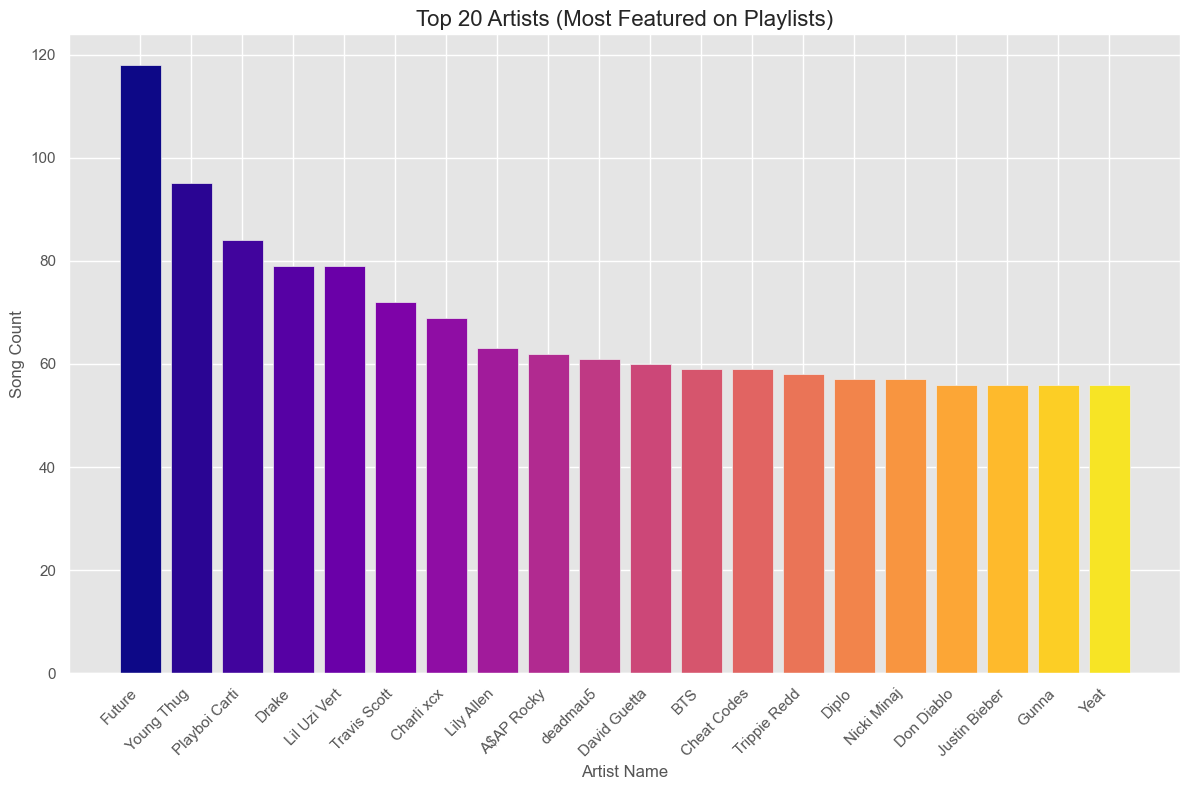

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def count_artists(df):
    # Ensure the 'Artist Name(s)' column is treated as a string
    df['Artist Name(s)'] = df['Artist Name(s)'].astype(str)
    
    # Split artist names by comma and explode the lists into separate rows
    df_exploded = df['Artist Name(s)'].str.split(',', expand=True).stack()
    df_exploded = df_exploded.reset_index(drop=True).str.strip()  # Remove extra spaces

    # Count occurrences of each artist
    artist_counts = df_exploded.value_counts()

    return artist_counts

# Assuming df_subset is your DataFrame
artist_counts = count_artists(df_subset[['Artist Name(s)']])

# Sort artists by count (descending) and get top 20
top_artists = artist_counts.nlargest(20)

# Extract artist names and counts
artist_names = top_artists.index
counts = top_artists.values

# Normalize the range for colors
norm = plt.Normalize(vmin=0, vmax=len(artist_names))

# Choose a colormap 
colormap = plt.cm.plasma

# Create color array based on the colormap
colors = colormap(norm(range(len(artist_names))))

# Create bar chart
plt.figure(figsize=(12, 8))
plt.bar(artist_names, counts, color=colors)
plt.xlabel("Artist Name", fontsize=12)
plt.ylabel("Song Count", fontsize=12)
plt.title("Top 20 Artists (Most Featured on Playlists)", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1765701238.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1765701238.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



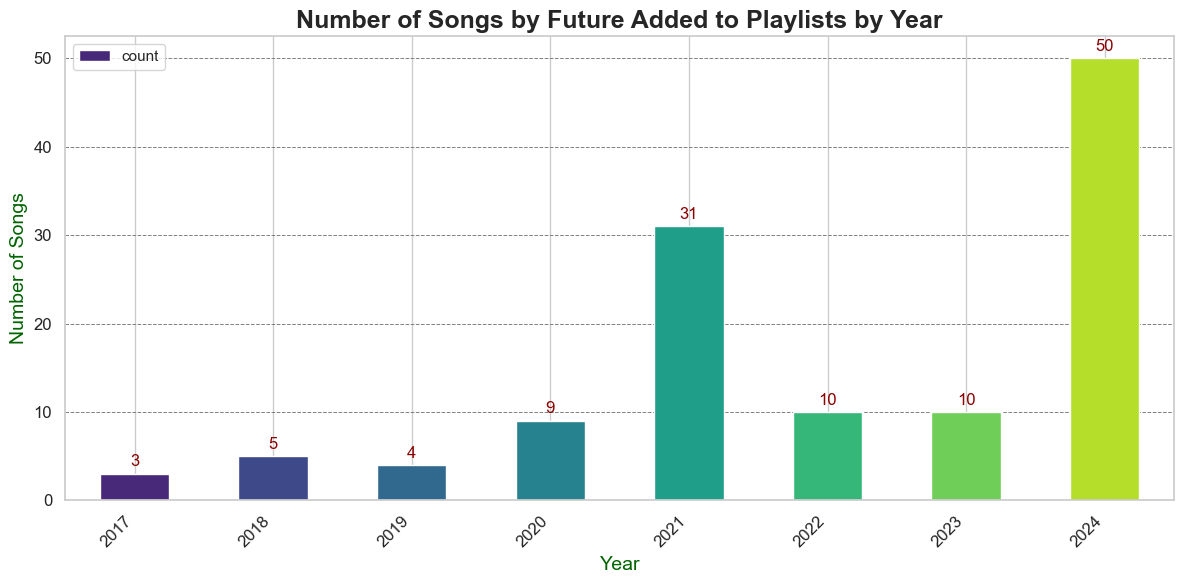

Total number of Future's songs: 122
Year with most songs: 2024 (50 songs)
Year with least songs: 2017 (3 songs)


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def preprocess_data(df):
    # Convert 'Added At' to datetime if it's not already
    df['Added At'] = pd.to_datetime(df['Added At'])
    
    # Filter data to include only songs by Future
    future_songs = df[df['Artist Name(s)'].str.contains('Future', case=False, na=False)]
    
    # Extract year from the "Added At" column
    future_songs['Year'] = future_songs['Added At'].dt.year
    
    # Calculate the number of songs listened to each year
    year_counts = future_songs['Year'].value_counts().sort_index()
    
    return future_songs, year_counts

def create_plot(year_counts):
    # Set a fun, colorful style
    sns.set(style="whitegrid")
    
    # Define a custom color palette for the years
    year_palette = sns.color_palette("viridis", n_colors=len(year_counts))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    bars = year_counts.plot(kind='bar', color=year_palette)
    
    # Add title and labels with a playful font style
    plt.title('Number of Songs by Future Added to Playlists by Year', fontsize=18, fontweight='bold')
    plt.xlabel('Year', fontsize=14, color='darkgreen')
    plt.ylabel('Number of Songs', fontsize=14, color='darkgreen')
    
    # Add counts on top of each bar
    for bar in bars.patches:
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.5,
                 f'{int(bar.get_height())}',
                 ha='center', va='bottom', fontsize=12, color='darkred')
    
    # Customize the x-ticks and grid
    plt.xticks(rotation=45, fontsize=12, ha='right')
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7, color='gray')
    
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    return plt

def main(df):
    future_songs, year_counts = preprocess_data(df)
    plt = create_plot(year_counts)
    plt.show()
    
    # Print some statistics
    print(f"Total number of Future's songs: {len(future_songs)}")
    print(f"Year with most songs: {year_counts.idxmax()} ({year_counts.max()} songs)")
    print(f"Year with least songs: {year_counts.idxmin()} ({year_counts.min()} songs)")

if __name__ == "__main__":
    # Assuming df_subset is your input dataframe
    main(df_subset)

### For my seasonal analyses henceforth I will use the following color palette to visually demark seasons
- Winter is denoted by Blue
- Spring is denoted by Green
- Summer is denoted by Yellow
- Autumn is denoted by Orange

In [89]:

season_palette = {'Winter': '#68c2e8', 'Spring': '#95d86e', 'Summer': '#ffdb58', 'Autumn': '#ff7f50'}

### This summer is a BRAT summer for me - but historically was that always the case?
#### Looks like spring is BRAT green! Each season is quite different, winter seemingly being all over the place since Disney, Britney Spears and BTS are all on there! 

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/2969257271.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/2969257271.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/2969257271.py:35: UserWarning:


The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/2969257271.py:35: FutureWarning:



Passing `palette` without assigning `hue` is d

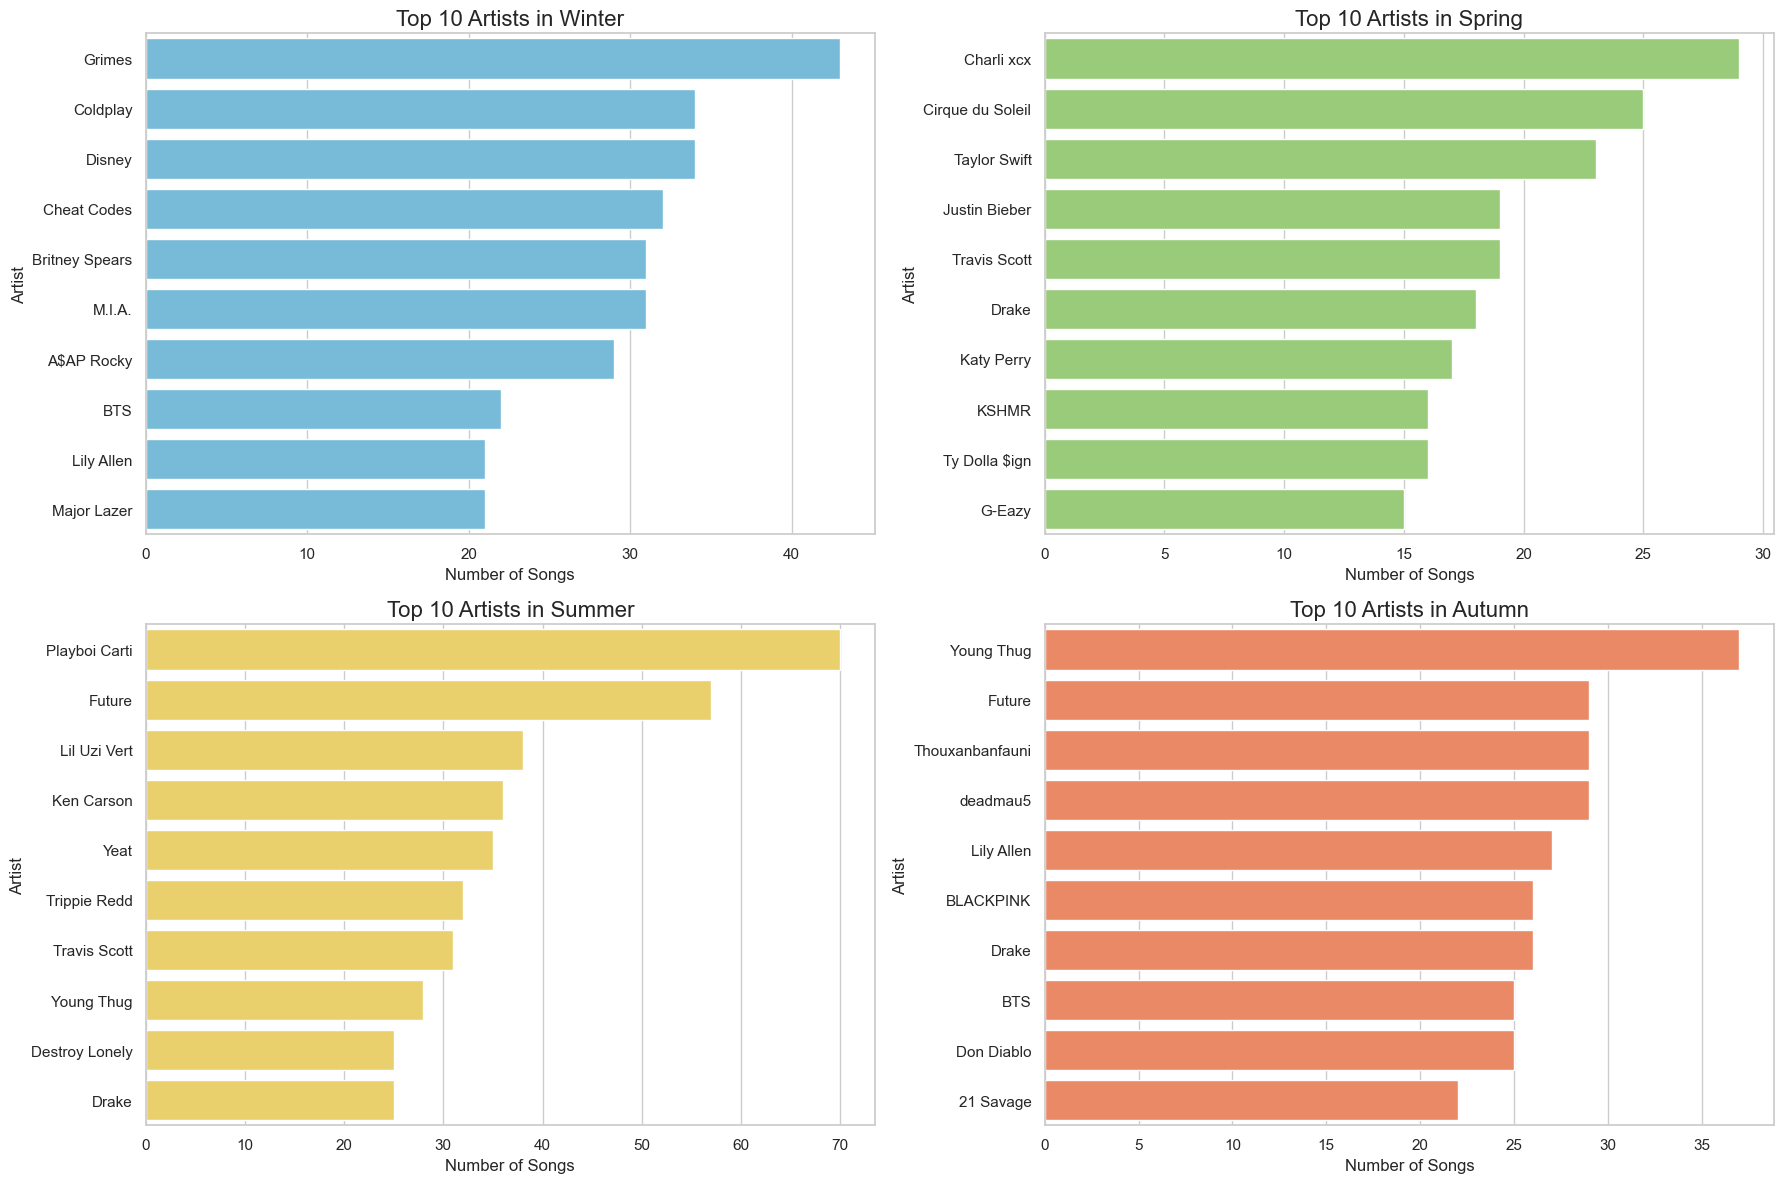

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def count_artists_by_season(df):
    # Ensure the 'Artist Name(s)' column is treated as a string
    df['Artist Name(s)'] = df['Artist Name(s)'].astype(str)
    
    # Split artist names by comma and explode the lists into separate rows
    df_exploded = df[['Artist Name(s)', 'Season']].copy()
    df_exploded['Artist Name(s)'] = df_exploded['Artist Name(s)'].str.split(',').apply(lambda x: [artist.strip() for artist in x])
    df_exploded = df_exploded.explode('Artist Name(s)')
    
    # Count occurrences of each artist by season
    artist_season_counts = df_exploded.groupby(['Artist Name(s)', 'Season']).size().reset_index(name='Count')

    return artist_season_counts

# Assuming df_subset is your DataFrame
artist_season_counts = count_artists_by_season(df_subset)

# Sorting and filtering to get the top 10 artists for each season
top_artists_by_season = artist_season_counts.sort_values(['Season', 'Count'], ascending=[True, False])
top_10_artists_by_season = top_artists_by_season.groupby('Season').head(10)


# Plotting the top 10 artists for each season
plt.figure(figsize=(18, 12))

for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Autumn']):
    plt.subplot(2, 2, i + 1)
    season_data = top_10_artists_by_season[top_10_artists_by_season['Season'] == season]
    
    # Create a bar plot
    sns.barplot(data=season_data, x='Count', y='Artist Name(s)', palette=[season_palette[season]])
    
    plt.title(f'Top 10 Artists in {season}', fontsize=16)
    plt.xlabel('Number of Songs')
    plt.ylabel('Artist')

plt.tight_layout()
plt.show()


### Looking at add volume over the years (by month and season) to see when I most actively added music to playlists
#### I was not surprised to see how erratic my playlist making was until 2022, which was when I started my first full time job, after which I was not curating my music as intentionally (makes sense as my work took up most of my time) and then in August 2024 there was a spike. 

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/3058003605.py:13: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



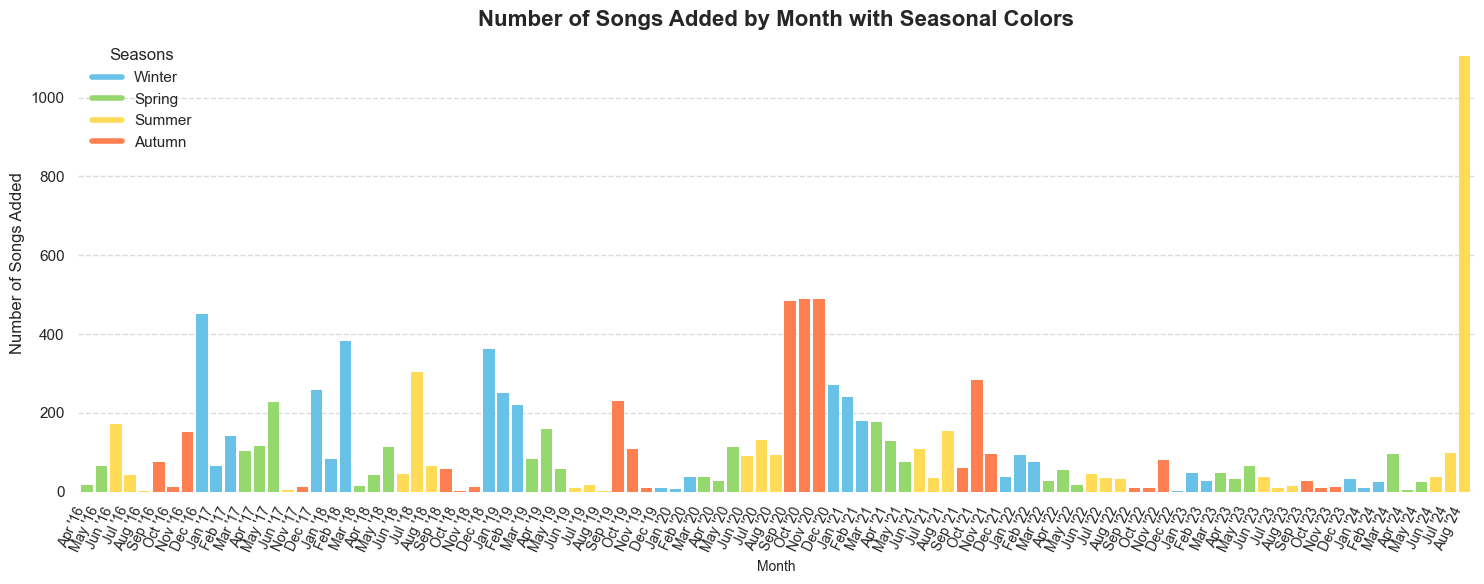

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_songs_by_month(df, season_palette):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()

    # Ensure 'Added At' is in datetime format
    df_copy['Added At'] = pd.to_datetime(df_copy['Added At'])

    # Create a new column 'YearMonth' as a datetime Period for grouping by year and month
    df_copy['YearMonth'] = df_copy['Added At'].dt.to_period('M')

    # Group by 'YearMonth' and count occurrences, sorting chronologically
    volume_by_month = df_copy.groupby(['YearMonth', 'Season']).size().sort_index()

    # Extract seasons for each YearMonth and map the colors
    colors = [season_palette[season] for _, season in volume_by_month.index]

    # Plotting
    plt.figure(figsize=(15, 6))
    ax = volume_by_month.plot(kind='bar', color=colors, edgecolor='none', width=0.8)

    # Formatting the plot
    plt.title('Number of Songs Added by Month with Seasonal Colors', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=10)
    plt.ylabel('Number of Songs Added', fontsize=12)

    # Customizing x-tick labels to be "Mon 'YY"
    xtick_labels = [period.strftime('%b \'%y') for period, _ in volume_by_month.index]
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, rotation=65, ha='right', fontsize=10)

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove gridlines
    plt.grid(False)

    # Adding a color key (legend) for seasons
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=season) for season, color in season_palette.items()]
    plt.legend(handles=legend_elements, title="Seasons", loc='upper left', frameon=False)

    # Add subtle horizontal lines for readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
    ax.set_axisbelow(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_songs_by_month(df_subset, season_palette)


### I tried to visualize this differently with no. of songs added by season over the years. I hypothesized I would be most active in the winter and summer, but it is clear that the pandemic in 2020 and my time being unemployed in 2024 are when I am most active. This coincides with when I was going through a lot in my personal life, too. 

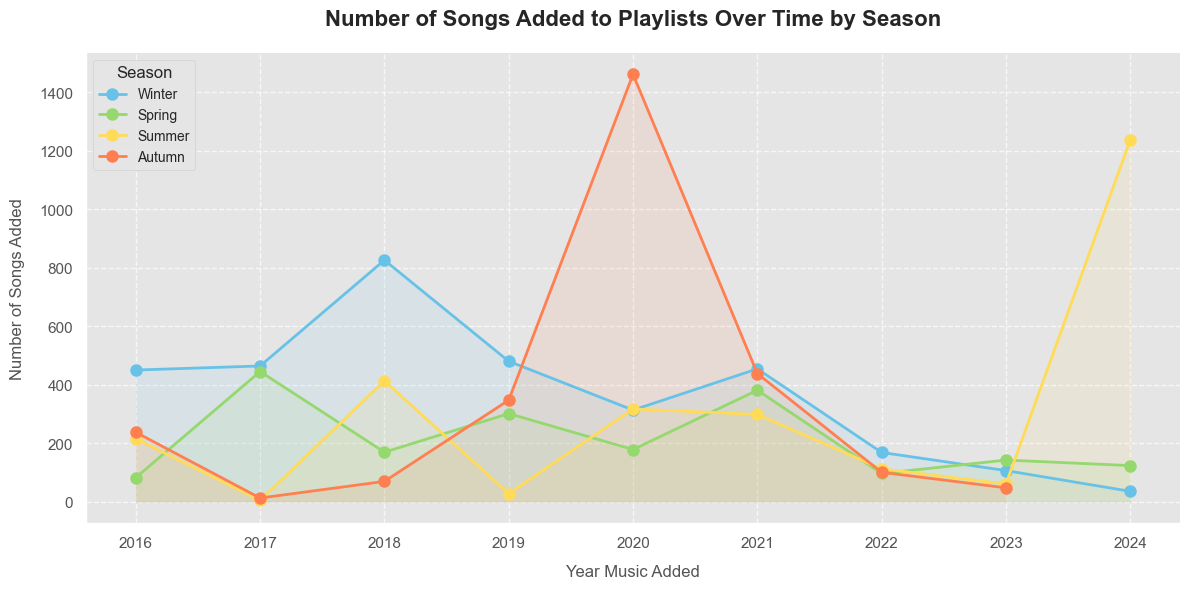

In [120]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_songs_over_time(df, season_palette):
    # Create a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()

    # Extract the year from 'Added At'
    df_copy['Added_Year'] = df_copy['Added At'].dt.year

    # Group by 'Added_Year' and 'Season', then count the number of songs
    count_df = df_copy.groupby(['Added_Year', 'Season']).size().reset_index(name='Number_of_Songs')

    # Set the style for the plot
    plt.style.use('ggplot')

    # Create a plot with a white background
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

    # Plot the number of songs added over time, segmented by season
    for season in season_palette:
        season_data = count_df[count_df['Season'] == season]
        ax.plot(season_data['Added_Year'], season_data['Number_of_Songs'], 
                color=season_palette[season], marker='o', markersize=8, linewidth=2, label=season)

    # Customize plot
    ax.set_title('Number of Songs Added to Playlists Over Time by Season', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Year Music Added', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of Songs Added', fontsize=12, labelpad=10)
    ax.legend(title='Season', title_fontsize='12', fontsize='10', loc='upper left', frameon=True)

    # Customize grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize x-axis
    ax.set_xticks(df_copy['Added_Year'].unique())
    ax.tick_params(axis='x', rotation=0)

    # Add subtle shading to emphasize the lines
    for season in season_palette:
        season_data = count_df[count_df['Season'] == season]
        ax.fill_between(season_data['Added_Year'], season_data['Number_of_Songs'], 
                        alpha=0.1, color=season_palette[season])

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage
plot_songs_over_time(df_subset, season_palette)


### Looking at add volume over the seasons to see when I most actively added music to playlists
#### This made sense to me because overall I did feel I was most active in the winter as I generally was on break when I was in college but also when the weather was extreme and I spent too much time indoors - meaning I leaned on music more to pass time.

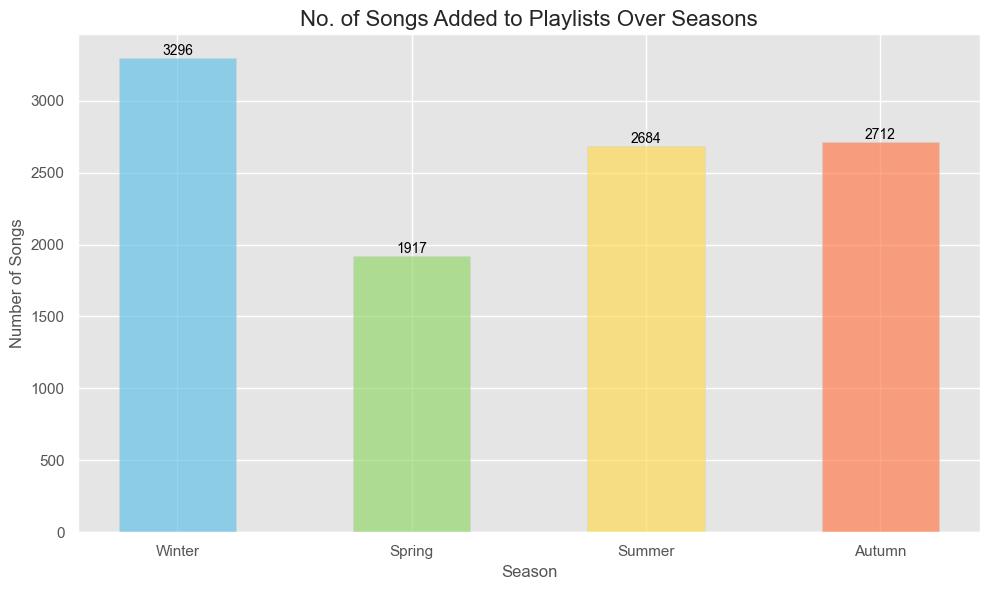

In [94]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(10, 6))

# Plot histograms for each season separately with slimmer bars and numbers above the bars
for season in season_palette:
    season_data = df_subset[df_subset['Season'] == season]
    
    # Adjust the 'rwidth' parameter to make bars slimmer
    bars = plt.hist(season_data['Season'], bins=1, edgecolor='lightgray', color=season_palette[season], 
                    alpha=0.7, label=season, rwidth=0.5)

    # Add numbers above the bars with a small vertical offset for better readability
    for i in range(len(bars[0])):
        plt.text(bars[1][i] + (bars[1][i+1] - bars[1][i]) / 2, bars[0][i] + 1, int(bars[0][i]), 
                 ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title('No. of Songs Added to Playlists Over Seasons', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)

# Optimize the layout
plt.tight_layout()

# Display the plot
plt.show()


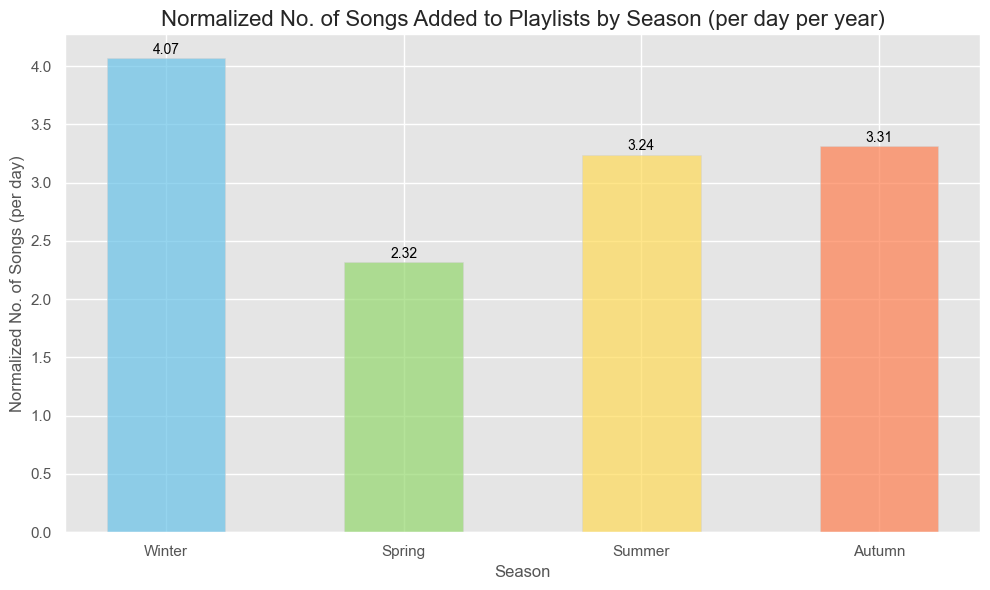

In [95]:
import matplotlib.pyplot as plt

# Number of days in each season
days_in_season = {'Winter': 90, 'Spring': 92, 'Summer': 92, 'Autumn': 91}  # Typical counts for Northern Hemisphere

# Prepare the plot
plt.figure(figsize=(10, 6))

# Plot histograms for each season separately with normalization by the number of days in the season
for season in season_palette:
    season_data = df_subset[df_subset['Season'] == season]
    
    # Normalize the count of songs by the number of days in the season
    normalized_count = len(season_data) / days_in_season[season]
    normalized_count = normalized_count/len(df_subset['Added At'].dt.year.unique())
    
    # Plot the bar with normalized values
    bars = plt.bar(season, normalized_count, color=season_palette[season], alpha=0.7, edgecolor='lightgray', width=0.5)
    
    # Add the normalized count above the bar
    plt.text(season, normalized_count + 0.01, f'{normalized_count:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title('Normalized No. of Songs Added to Playlists by Season (per day per year)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Normalized No. of Songs (per day)', fontsize=12)

# Optimize the layout
plt.tight_layout()

# Display the plot
plt.show()


### I tried visualizing seasonal distributions for various other music traits, like Danceability, Valence, Energy and Tempo, to get a general sense of what kind of music I liked in different seasons. 
#### This visual made it clear that my taste seems fairly consistent across the seasons but that overall I like songs that you can dance to, have high energy and high tempo! Ya girl like music she can have a good time to!

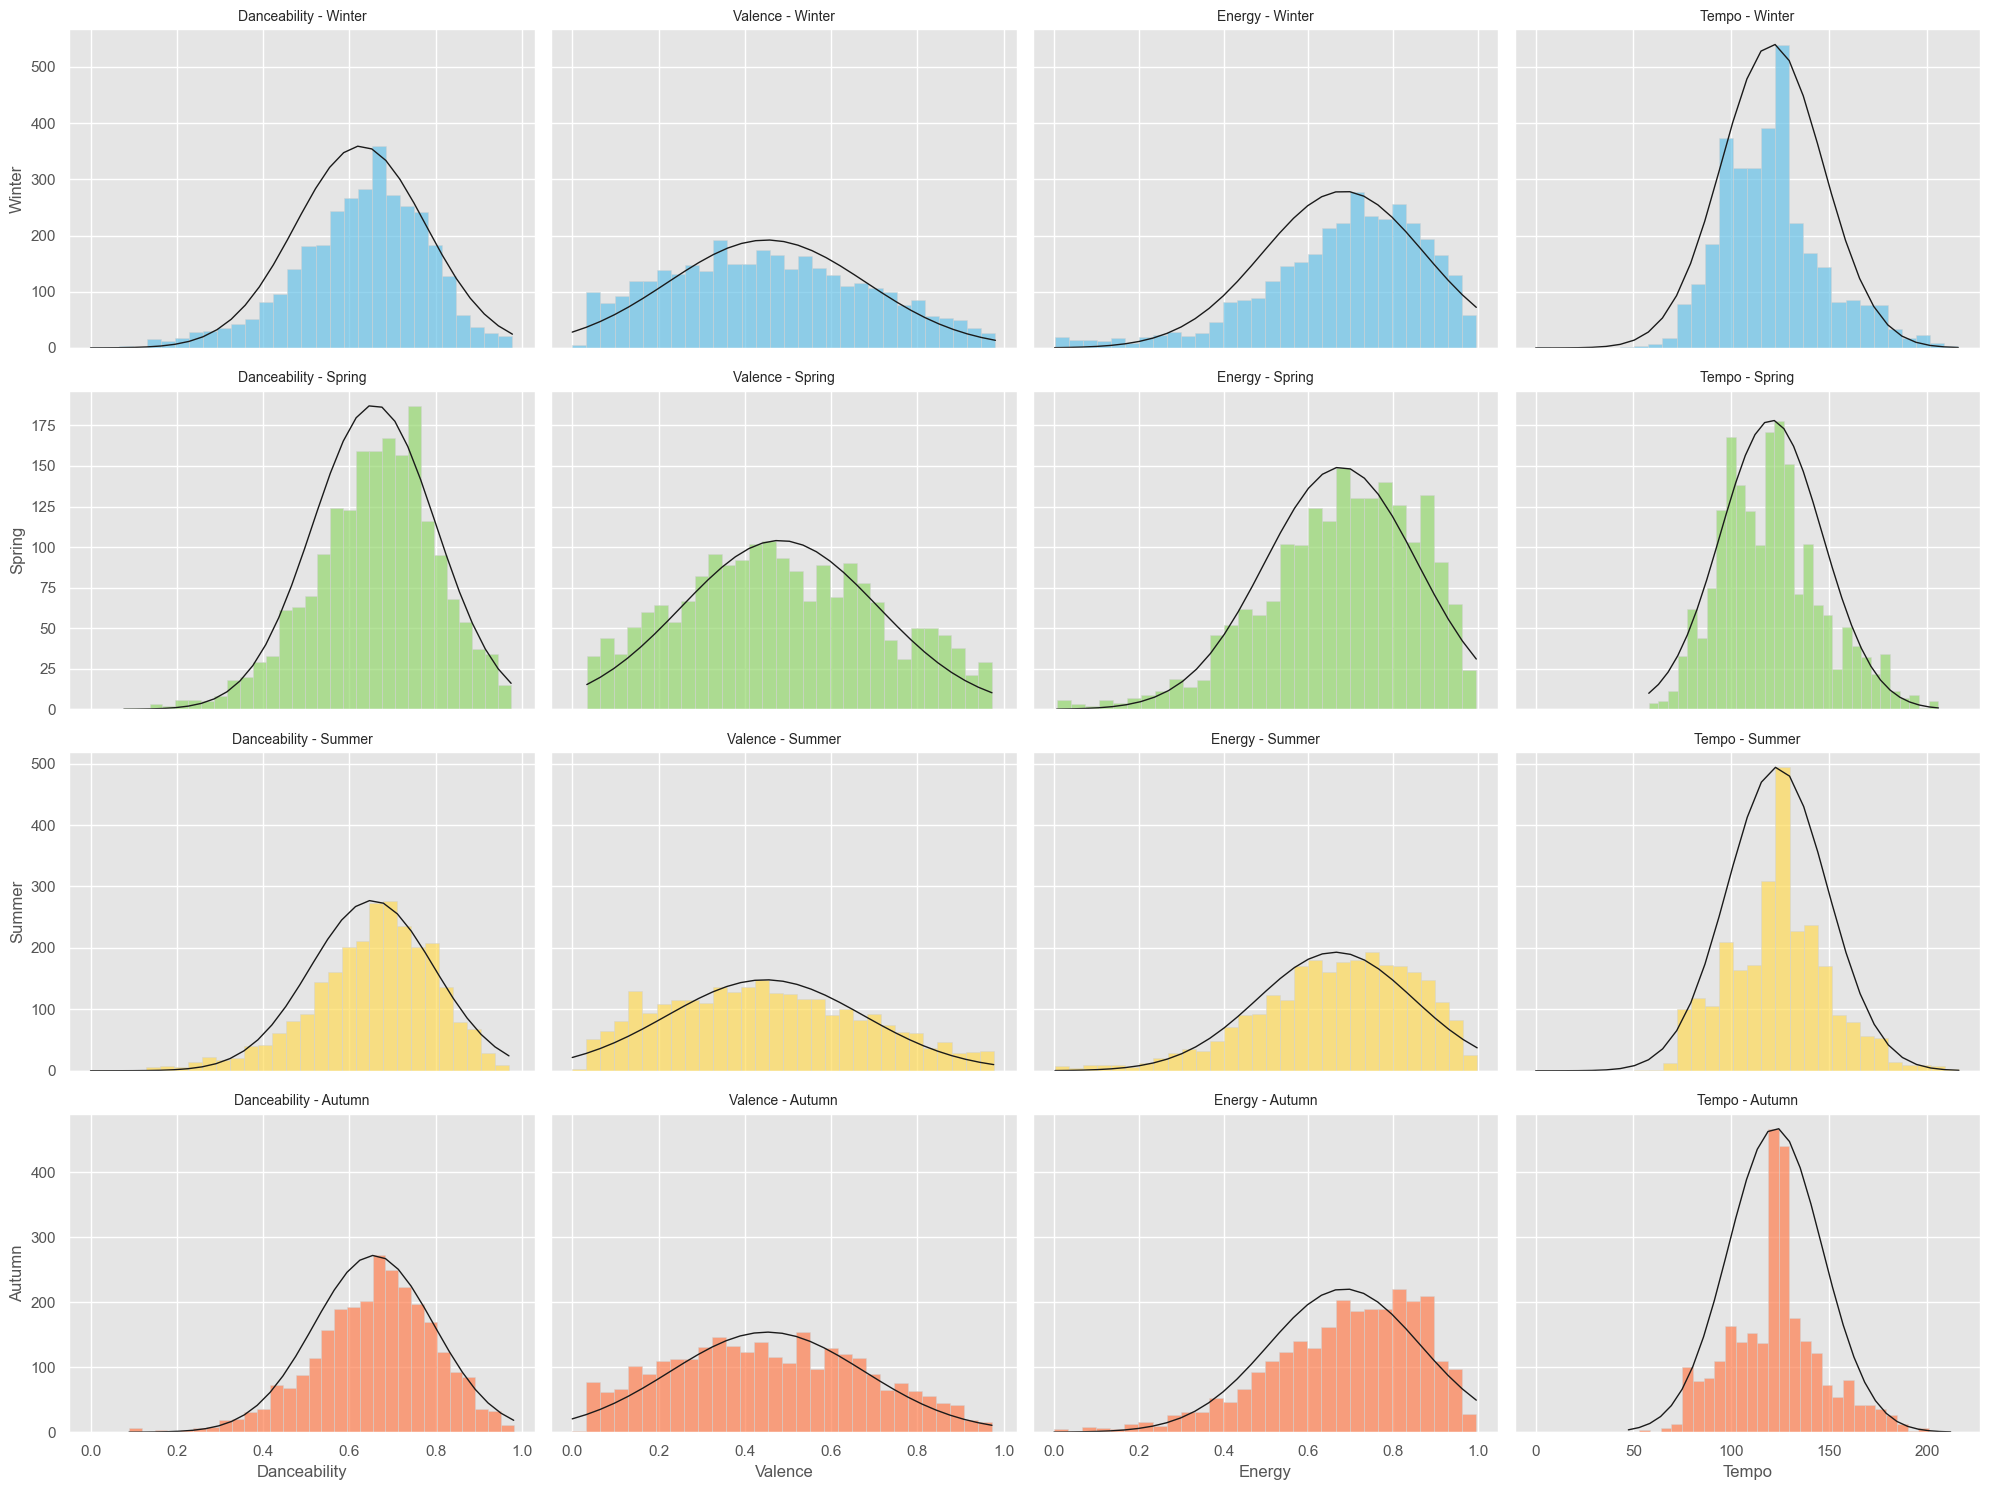

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# List of attributes to plot
attributes = ['Danceability', 'Valence','Energy', 'Tempo']

# Number of seasons
seasons = df_subset['Season'].unique()

# Create subplots: one for each season, with a grid of attributes
fig, axes = plt.subplots(len(seasons), len(attributes), figsize=(20, 15), sharex='col', sharey='row')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each attribute per season
for i, season in enumerate(seasons):
    df_season = df_subset[df_subset['Season'] == season]
    for j, attribute in enumerate(attributes):
        ax = axes[i * len(attributes) + j]
        data = df_season[attribute].dropna()  # Drop NaN values if any

        # Plot histogram
        n, bins, patches = ax.hist(data, bins=30, alpha=0.7, color=season_palette[season], edgecolor='lightgrey')

        # Add trend line (using a normal distribution fit for simplicity)
        if len(data) > 1:  # Ensure there is enough data to fit a trend line
            mu, std = norm.fit(data)
            p = norm.pdf(bins, mu, std)
            ax.plot(bins, p * max(n) / max(p), 'k-', linewidth=1)  # Normalize to match histogram height

        # Set labels and titles
        if i == len(seasons) - 1:
            ax.set_xlabel(attribute)
        if j == 0:
            ax.set_ylabel(season)
        ax.set_title(f'{attribute} - {season}', fontsize=10)
        
        # Format x-axis labels for 'Duration (s)'
        if attribute == 'Duration (s)':
            ax.set_xticks(np.arange(0, max(data) + 1, step=max(data) / 10))  # Adjust step for better readability
            ax.set_xticklabels([f'{int(x):,}' for x in ax.get_xticks()])  # Format labels with commas for readability

# Adjust layout for better readability
plt.tight_layout()
plt.show()


### Then I look at the same thing by year!

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm
import pandas as pd
import matplotlib.cm as cm
import ipywidgets as widgets
from IPython.display import display

# Ensure the "Added At" column is in datetime format and convert from UTC to local time (if required)
df_subset.loc[:, 'Added At2'] = pd.to_datetime(df_subset['Added At']).dt.tz_localize(None)  # Convert to naive datetime

# Extract unique years from the data
years = df_subset['Added At2'].dt.year.unique()
years.sort()  # Sort years for consistent plotting

# List of attributes to plot
attributes = ['Danceability', 'Valence', 'Energy', 'Tempo']

# Generate a distinct color for each year using a darker colormap
colors = cm.get_cmap('tab10', len(years))  # Use 'tab10' colormap for distinct colors

# Create a color gradient for each year using LinearSegmentedColormap
gradients = [LinearSegmentedColormap.from_list(f'{year}_gradient', [colors(i / len(years)), 'lightgrey'], N=len(attributes)) 
             for i, year in enumerate(years)]

def plot_histograms(year):
    # Filter for the selected year
    df_year = df_subset[df_subset['Added At2'].dt.year == year]

    # Create subplots: one column for each attribute
    fig, axes = plt.subplots(1, len(attributes), figsize=(20, 5), sharex='col', sharey='row')

    # Plot histograms for each attribute for the selected year with gradient colors
    for j, attribute in enumerate(attributes):
        ax = axes[j]
        data = df_year[attribute].dropna()  # Drop NaN values if any

        # Use gradient color for the attribute
        color = gradients[years.tolist().index(year)](j / (len(attributes) + 2))  # Get the color from the gradient

        # Plot histogram with the gradient color
        n, bins, patches = ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='lightgrey')

        # Add trend line (using a normal distribution fit for simplicity)
        if len(data) > 1:  # Ensure there is enough data to fit a trend line
            mu, std = norm.fit(data)
            p = norm.pdf(bins, mu, std)
            ax.plot(bins, p * max(n) / max(p), 'k-', linewidth=1)  # Normalize to match histogram height

            # Calculate and print the mean on the histogram
            ax.text(0.95, 0.95, f'Mean: {mu:.2f}', 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

        # Set labels and titles
        ax.set_xlabel(attribute)
        ax.set_title(f'{attribute}')

    # Set a title across the top of the entire plot block
    fig.suptitle(f'Attribute Distributions for {year}', fontsize=20, fontweight='bold')

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin to make room for suptitle
    plt.show()

# Create a dropdown widget for year selection
year_dropdown = widgets.Dropdown(
    options=[(str(year), year) for year in years],
    value=years[0],
    description='Year:',
)

# Display the dropdown and link it to the plotting function
widgets.interactive(plot_histograms, year=year_dropdown)


/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1891355212.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1891355212.py:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



interactive(children=(Dropdown(description='Year:', options=(('2016', 2016), ('2017', 2017), ('2018', 2018), (…

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm
import pandas as pd
import matplotlib.cm as cm
import ipywidgets as widgets
from IPython.display import display


# Extract unique years and seasons from the data
years = df_subset['Added At2'].dt.year.unique()
years.sort()  # Sort years for consistent plotting
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# List of attributes to plot
attributes = ['Danceability', 'Valence', 'Energy', 'Tempo']

# Define color palette for seasons
season_palette = {'Winter': '#68c2e8', 'Spring': '#95d86e', 'Summer': '#ffdb58', 'Autumn': '#ff7f50'}

def plot_histograms(year):
    # Filter for the selected year
    df_year = df_subset[df_subset['Added At2'].dt.year == year]

    # Create subplots: 4 rows (one for each season) and 4 columns (one for each attribute)
    fig, axes = plt.subplots(len(seasons), len(attributes), figsize=(20, 15), sharex='col', sharey='row')

    # Plot histograms for each attribute and season for the selected year
    for i, season in enumerate(seasons):
        df_season = df_year[df_year['Season'] == season]
        for j, attribute in enumerate(attributes):
            ax = axes[i, j]
            data = df_season[attribute].dropna()  # Drop NaN values if any

            # Plot histogram with the season color
            color = season_palette[season]
            n, bins, patches = ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='lightgrey')

            # Add trend line (using a normal distribution fit for simplicity)
            if len(data) > 1:  # Ensure there is enough data to fit a trend line
                mu, std = norm.fit(data)
                p = norm.pdf(bins, mu, std)
                ax.plot(bins, p * max(n) / max(p), 'k-', linewidth=1)  # Normalize to match histogram height

                # Calculate and print the mean on the histogram
                ax.text(0.95, 0.95, f'Mean: {mu:.2f}', 
                        transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

            # Set labels and titles
            if i == len(seasons) - 1:  # Bottom row
                ax.set_xlabel(attribute)
            if j == 0:  # First column
                ax.set_ylabel(season)
            ax.set_title(f'{attribute}', fontsize=10)

    # Add a super title for the entire figure
    fig.suptitle(f'Attribute Distributions for Playlists in {year}', fontsize=16, y=1.02)

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for year selection
year_dropdown = widgets.Dropdown(
    options=[(str(year), year) for year in years],
    value=years[0],
    description='Year:',
)

# Display the dropdown and link it to the plotting function
widgets.interactive(plot_histograms, year=year_dropdown)


interactive(children=(Dropdown(description='Year:', options=(('2016', 2016), ('2017', 2017), ('2018', 2018), (…

In [99]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

# Sort the DataFrame by the "Added At2" column
df_subset.sort_values('Added At2', inplace=True)

window_size = 30  # Adjust the window size as needed
df_subset['Valence_MA'] = df_subset['Valence'].rolling(window=window_size, min_periods=1).mean()

# Create interactive plot with Plotly
fig = go.Figure()

# Add scatter plot for Valence
fig.add_trace(go.Scatter(x=df_subset['Added At2'], y=df_subset['Valence'], mode='markers+lines', name='Valence',
                         line=dict(color='royalblue'), marker=dict(size=5, color='royalblue', opacity=0.5)))

# Add line plot for Moving Average
fig.add_trace(go.Scatter(x=df_subset['Added At2'], y=df_subset['Valence_MA'], mode='lines', name=f'{window_size}-Day Moving Average',
                         line=dict(color='red', width=2)))

# Update layout for better readability
fig.update_layout(
    title='Valence Over Time with Moving Average',
    xaxis_title='Date Added',
    yaxis_title='Valence',
    xaxis=dict(
        title='Date Added',
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(
        title='Valence'
    ),
    autosize=True
)

# Show the plot
fig.show()


/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1096845103.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1096845103.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Knowing what I know about valence, I tried to track average monthly valence and map them to life events

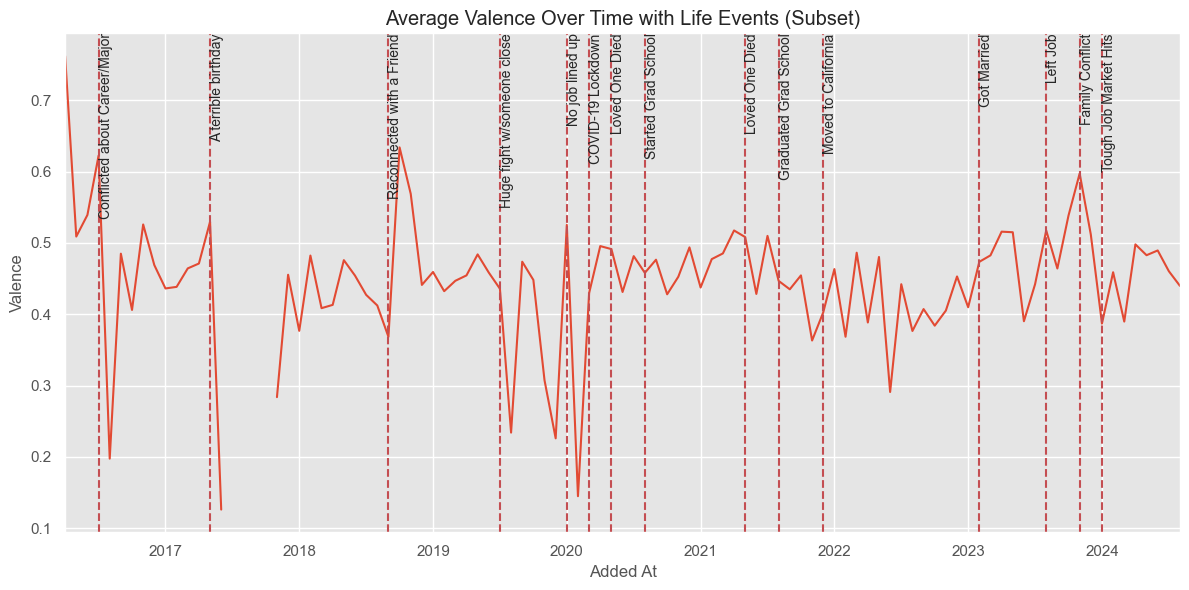

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# UDF to calculate monthly average valence without altering df_subset
def calculate_monthly_valence(df):
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid altering the original
    df_copy['Added At'] = pd.to_datetime(df_copy['Added At'])
    df_copy = df_copy.set_index('Added At')
    
    # Calculate monthly average valence
    monthly_valence = df_copy['Valence'].resample('M').mean()
    return monthly_valence

# Use the UDF on df_subset
monthly_valence_subset = calculate_monthly_valence(df_subset)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 6))
monthly_valence_subset.plot(ax=ax)

# Add annotations for life events
life_events = {
    '2016-07-10': 'Conflicted about Career/Major',
    '2017-05-04': 'A terrible birthday',
    '2018-09-20': 'Reconnected with a Friend',
    '2019-07-17': 'Huge fight w/someone close',
    '2020-01-01': 'No job lined up',
    '2020-03-15': 'COVID-19 Lockdown',
    '2020-05-03': 'Loved One Died',
    '2020-08-10': 'Started Grad School',
    '2021-05-05': 'Loved One Died',
    '2021-08-10': 'Graduated Grad School',
    '2021-12-28': 'Moved to California',
    '2023-02-10': 'Got Married',
    '2023-08-04': 'Left Job',
    '2023-11-01': 'Family Conflict',
    '2024-01-01': 'Tough Job Market Hits',
    # Add more events as needed
}

for date, event in life_events.items():
    ax.axvline(x=pd.to_datetime(date), color='r', linestyle='--')
    ax.text(pd.to_datetime(date), ax.get_ylim()[1], event, rotation=90, va='top')

plt.title("Average Valence Over Time with Life Events (Subset)")
plt.ylabel("Valence")
plt.tight_layout()
plt.show()


### I thought it would be interesting to see what my top 10 genres were by season and if they varied at all.

#### In short, barely. I still am basic as hell and listen to a lot of pop, however the genres following that moved around but were only edm, hip hop, rap or some pop variation. What was surprsing to me was the random appearance of 'Modern Rock' in the Wintertime. Wintertime Blues, I guess?

In [101]:
df_exploded = df_subset.assign(Genres=df_subset['Genres'].str.split(',')).explode('Genres')

# Group by Season and Genre and count occurrences
genre_counts_by_season = df_exploded.groupby(['Season', 'Genres']).size().reset_index(name='Count')

# Sort by Season and count in descending order
top_genres_by_season = genre_counts_by_season.sort_values(['Season', 'Count'], ascending=[True, False])

# Get the top 10 genres for each season
top_10_genres_by_season = top_genres_by_season.groupby('Season').head(10)

In [102]:
df_exploded

,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Added At,Genres,Valence,Danceability,Energy,Tempo,Playlist,Season,Added At2,Valence_MA
3449,Desi Girl,Dostana (Original Motion Picture Soundtrack),"Vishal-Shekhar,Shankar Mahadevan,Sunidhi Chauh...",2008-10-08,306986,2016-04-25 23:31:24+00:00,filmi,0.81,0.75,0.92,136.05,54n5k4r1,Spring,2016-04-25 23:31:24,0.81
3449,Desi Girl,Dostana (Original Motion Picture Soundtrack),"Vishal-Shekhar,Shankar Mahadevan,Sunidhi Chauh...",2008-10-08,306986,2016-04-25 23:31:24+00:00,modern bollywood,0.81,0.75,0.92,136.05,54n5k4r1,Spring,2016-04-25 23:31:24,0.81
3450,Tum Tak,Raanjhanaa (Original Motion Picture Soundtrack),"A.R. Rahman,Javed Ali,KIRTI SAGATHIA,Pooja AV",2013-05-31,304466,2016-04-25 23:31:56+00:00,filmi,0.57,0.72,0.62,114.99,54n5k4r1,Spring,2016-04-25 23:31:56,0.69
3450,Tum Tak,Raanjhanaa (Original Motion Picture Soundtrack),"A.R. Rahman,Javed Ali,KIRTI SAGATHIA,Pooja AV",2013-05-31,304466,2016-04-25 23:31:56+00:00,desi pop,0.57,0.72,0.62,114.99,54n5k4r1,Spring,2016-04-25 23:31:56,0.69
3450,Tum Tak,Raanjhanaa (Original Motion Picture Soundtrack),"A.R. Rahman,Javed Ali,KIRTI SAGATHIA,Pooja AV",2013-05-31,304466,2016-04-25 23:31:56+00:00,modern bollywood,0.57,0.72,0.62,114.99,54n5k4r1,Spring,2016-04-25 23:31:56,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,Nuketown (feat. Juice WRLD),STOKELEY,"Ski Mask The Slump God,Juice WRLD",2018-11-30,166400,2024-08-15 07:40:54+00:00,underground hip hop,0.63,0.81,0.62,149.96,clean,Summer,2024-08-15 07:40:54,0.34
3069,Nuketown (feat. Juice WRLD),STOKELEY,"Ski Mask The Slump God,Juice WRLD",2018-11-30,166400,2024-08-15 07:40:54+00:00,chicago rap,0.63,0.81,0.62,149.96,clean,Summer,2024-08-15 07:40:54,0.34
3069,Nuketown (feat. Juice WRLD),STOKELEY,"Ski Mask The Slump God,Juice WRLD",2018-11-30,166400,2024-08-15 07:40:54+00:00,melodic rap,0.63,0.81,0.62,149.96,clean,Summer,2024-08-15 07:40:54,0.34
3073,WHERE I BE,WAKE UP LUCKI,"LUCKI,F1LTHY",2021-12-03,132733,2024-08-15 07:40:54+00:00,plugg,0.13,0.64,0.46,134.06,clean,Summer,2024-08-15 07:40:54,0.33


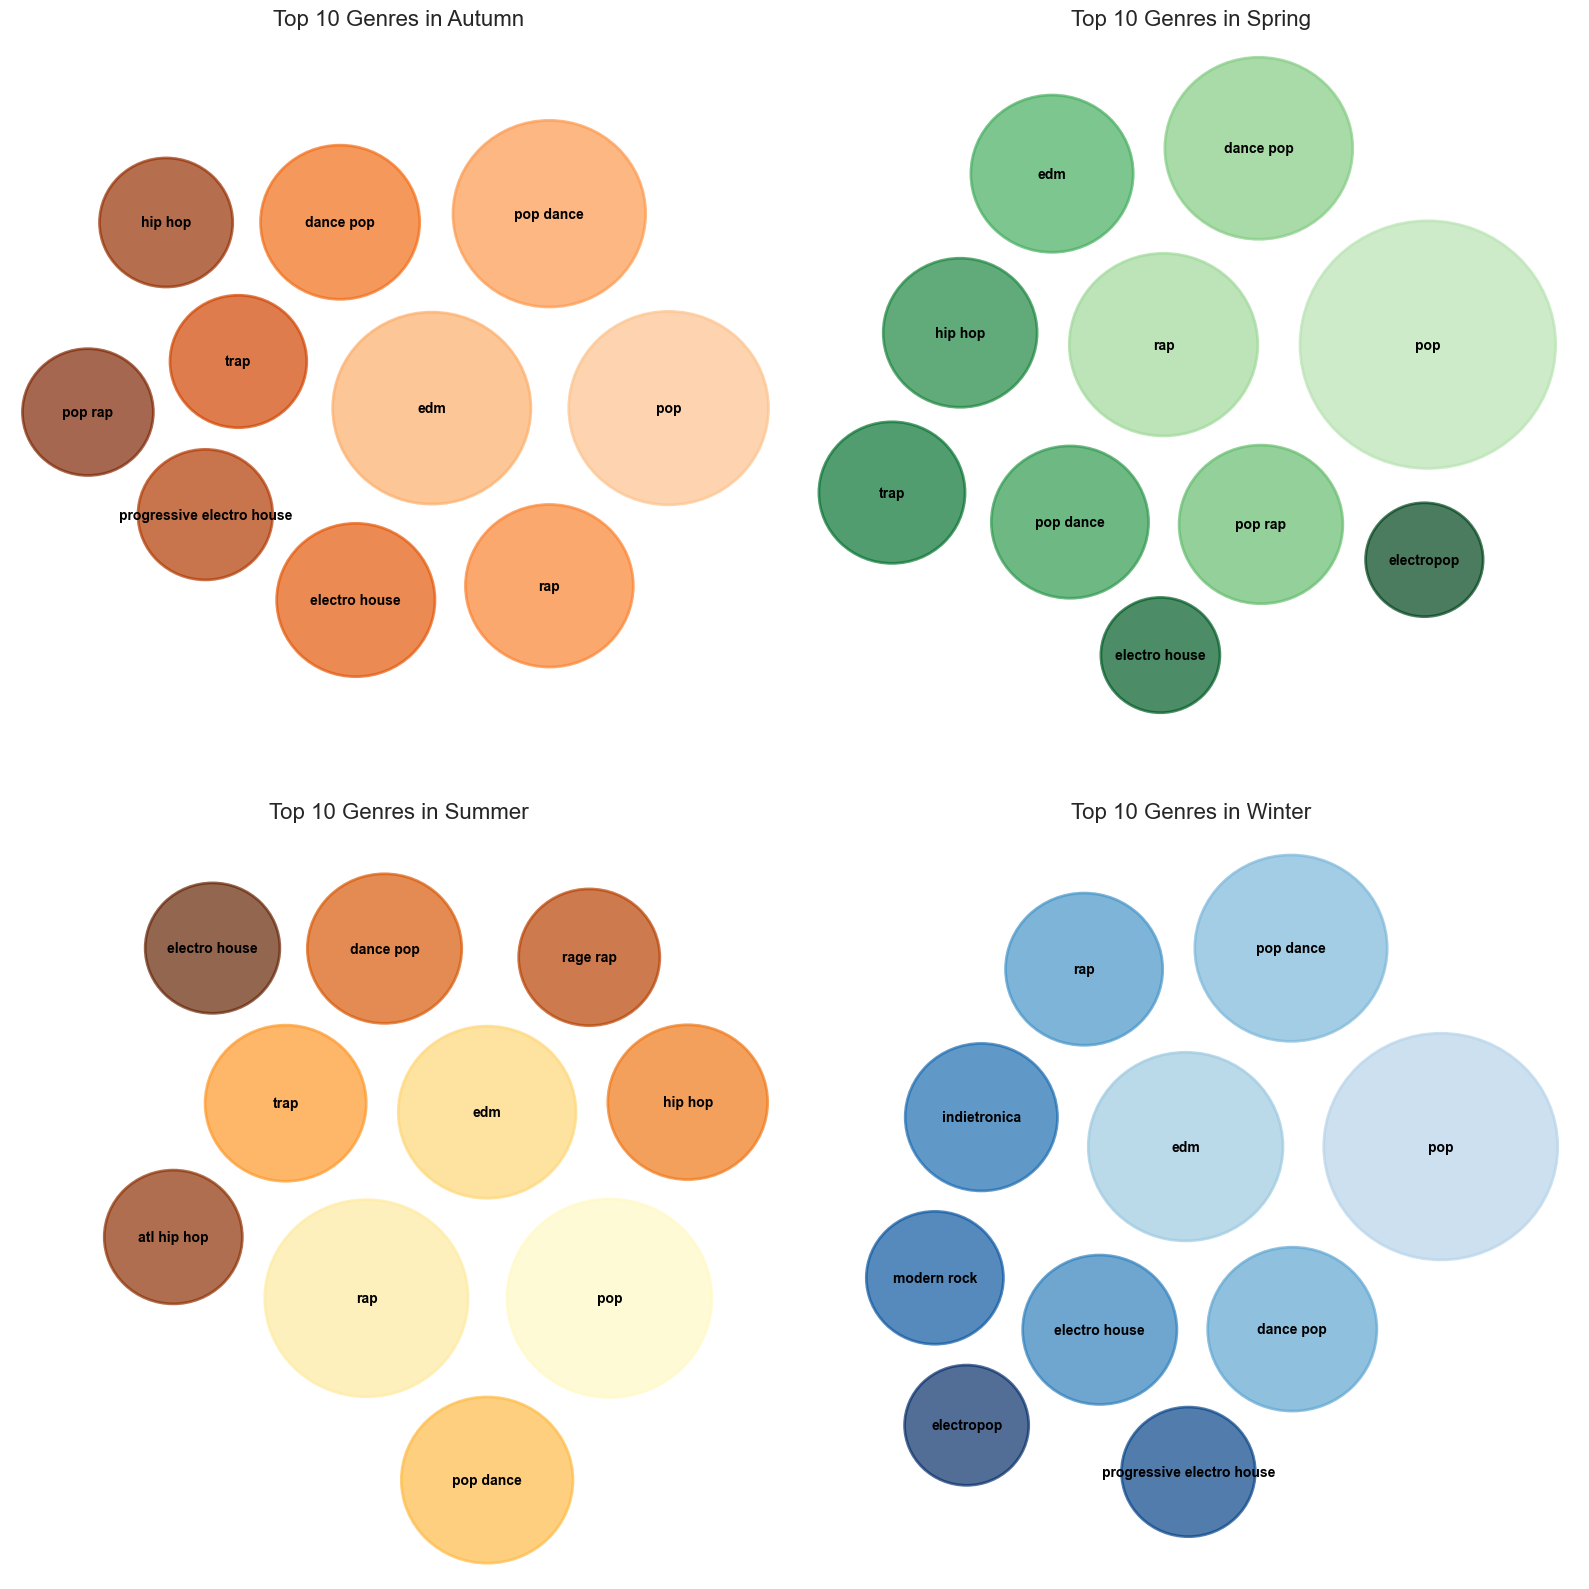

In [103]:
import matplotlib.pyplot as plt
import circlify
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd

# Define color palettes for each season
season_colors = {
    'Winter': plt.cm.Blues(np.linspace(0.3, 1, 10)),
    'Autumn': plt.cm.Oranges(np.linspace(0.3, 1, 10)),
    'Summer': plt.cm.YlOrBr(np.linspace(0.1, 1, 10)),
    'Spring': plt.cm.Greens(np.linspace(0.3, 1, 10))
}

# Create a figure with 4 subplots (2x2 grid)
plt.figure(figsize=(16, 16))

# Iterate over each season and create a circlify plot
seasons = top_10_genres_by_season['Season'].unique()

for i, season in enumerate(seasons):
    plt.subplot(2, 2, i + 1)
    
    # Filter data for the current season
    season_data = top_10_genres_by_season[top_10_genres_by_season['Season'] == season]
    
    # Compute circle positions
    circles = circlify.circlify(
        season_data['Count'].tolist(),
        show_enclosure=False,
        target_enclosure=circlify.Circle(x=0, y=0, r=1)
    )
    
    # Reverse the order of the circles to match the order of data
    circles = circles[::-1]
    
    # Set title for the subplot
    plt.title(f'Top 10 Genres in {season}', fontsize=16)
    
    # Remove axes
    plt.axis('off')
    
    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    
    # List of labels and colors
    labels = season_data['Genres']
    colors = season_colors[season]  # Use the seasonal color palette

    # Create a dictionary for the legend
    legend_labels = []

    # Print circles
    for j, (circle, label) in enumerate(zip(circles, labels)):
        x, y, r = circle.x, circle.y, circle.r
        # Increase the circle radius to add space between circles
        r *= 1.2
        color = colors[j % len(colors)]
        plt.gca().add_patch(plt.Circle((x, y), r*0.7, alpha=0.7, linewidth=2, color=color))
        # Make circle labels smaller
        plt.annotate(
            label,
            (x, y),
            va='center',
            ha='center',
            fontsize=10,  # Adjusted font size for readability
            fontweight='bold',
            color='black'
        )
        legend_labels.append(label)

plt.tight_layout()
plt.show()


### Looking at the top 20 music genres I listened to the most every season (a different way to visualize something I did above)

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1032607903.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



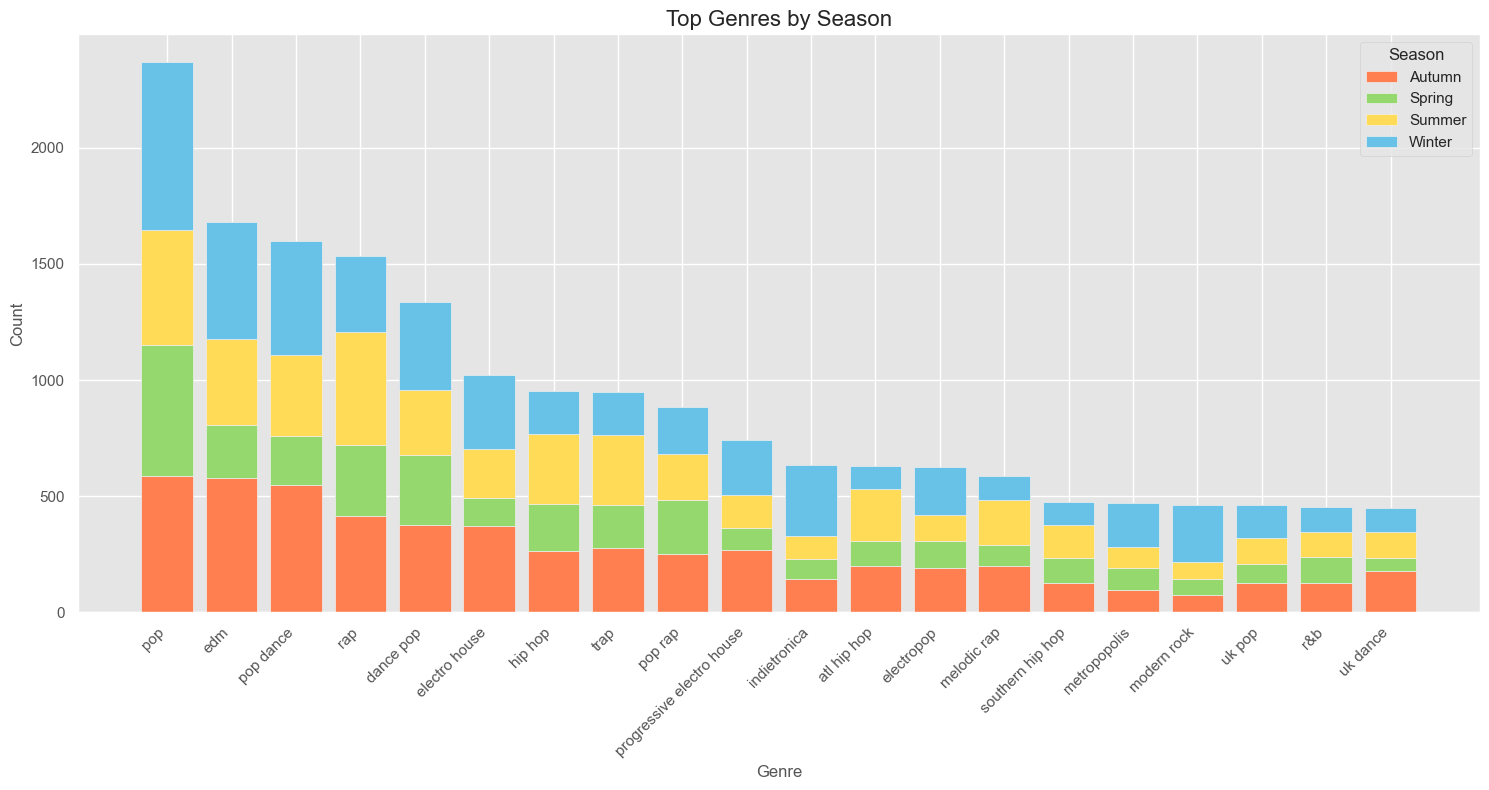

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the UDF to process the DataFrame and calculate the top 20 genres by season
def calculate_top_genres_by_season(df, season_palette):
    # Step 1: Split the Genres column into a list and explode
    df['Genres'] = df['Genres'].str.split(',')
    df = df.explode('Genres')

    # Step 2: Strip whitespace from genres
    df['Genres'] = df['Genres'].str.strip()

    # Step 3: Count occurrences of each genre for each season
    genre_counts = df.groupby(['Genres', 'Season']).size().unstack(fill_value=0)

    # Step 4: Calculate total count for each genre across all seasons
    genre_counts['Total'] = genre_counts.sum(axis=1)

    # Step 5: Sort by total count and select top 20 genres
    top_20_genres = genre_counts.nlargest(20, 'Total')

    # Step 6: Create the final DataFrame with genres and seasonal counts
    top_20_genres_by_season = pd.DataFrame({
        'Genre': top_20_genres.index,
        'Total': top_20_genres['Total']
    })

    # Add columns for each season present in the data
    for season in genre_counts.columns:
        if season != 'Total':
            top_20_genres_by_season[season] = top_20_genres[season]

    # Sort by Total in descending order
    top_20_genres_by_season = top_20_genres_by_season.sort_values('Total', ascending=False).reset_index(drop=True)

    return top_20_genres_by_season

# Use the UDF on the df_subset
top_20_genres_by_season = calculate_top_genres_by_season(df_subset, season_palette)

# Plotting the data
plt.figure(figsize=(15, 8))

# Get the season columns (excluding 'Genre' and 'Total')
seasons = [col for col in top_20_genres_by_season.columns if col not in ['Genre', 'Total']]

# Create the stacked bar plot
bottom = pd.Series(0, index=top_20_genres_by_season.index)
for season in seasons:
    plt.bar(top_20_genres_by_season['Genre'], top_20_genres_by_season[season], 
            bottom=bottom, label=season, color=season_palette.get(season, 'gray'))  # Use seasonal colors
    bottom += top_20_genres_by_season[season]

# Customize the plot
plt.title('Top Genres by Season', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Season')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### To see this in more detail, I created a stacked Bar Chart for top genres over the years by season

2024-08-29 16:17:52,309 - INFO - Input DataFrame shape: (10609, 15)
2024-08-29 16:17:52,310 - INFO - Input DataFrame columns: Index(['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
       'Duration (ms)', 'Added At', 'Genres', 'Valence', 'Danceability',
       'Energy', 'Tempo', 'Playlist', 'Season', 'Added At2', 'Valence_MA'],
      dtype='object')
2024-08-29 16:17:52,329 - INFO - Exploded DataFrame shape: (44817, 16)
2024-08-29 16:17:52,333 - INFO - Unique genres: ['filmi' 'modern bollywood' 'desi pop' ... 'german cloud rap'
 'german hip hop' 'atl drill']
2024-08-29 16:17:52,356 - INFO - Final DataFrame shape: (35, 38)
2024-08-29 16:17:52,361 - INFO - Final DataFrame:
Genres       atl hip hop  british soundtrack  brostep  chillhop  chutney  \
Year Season                                                                
2016 Autumn         0.00                0.00     0.00      0.00     0.00   
     Spring         0.00                0.00     0.00      0.00     2.24   
   

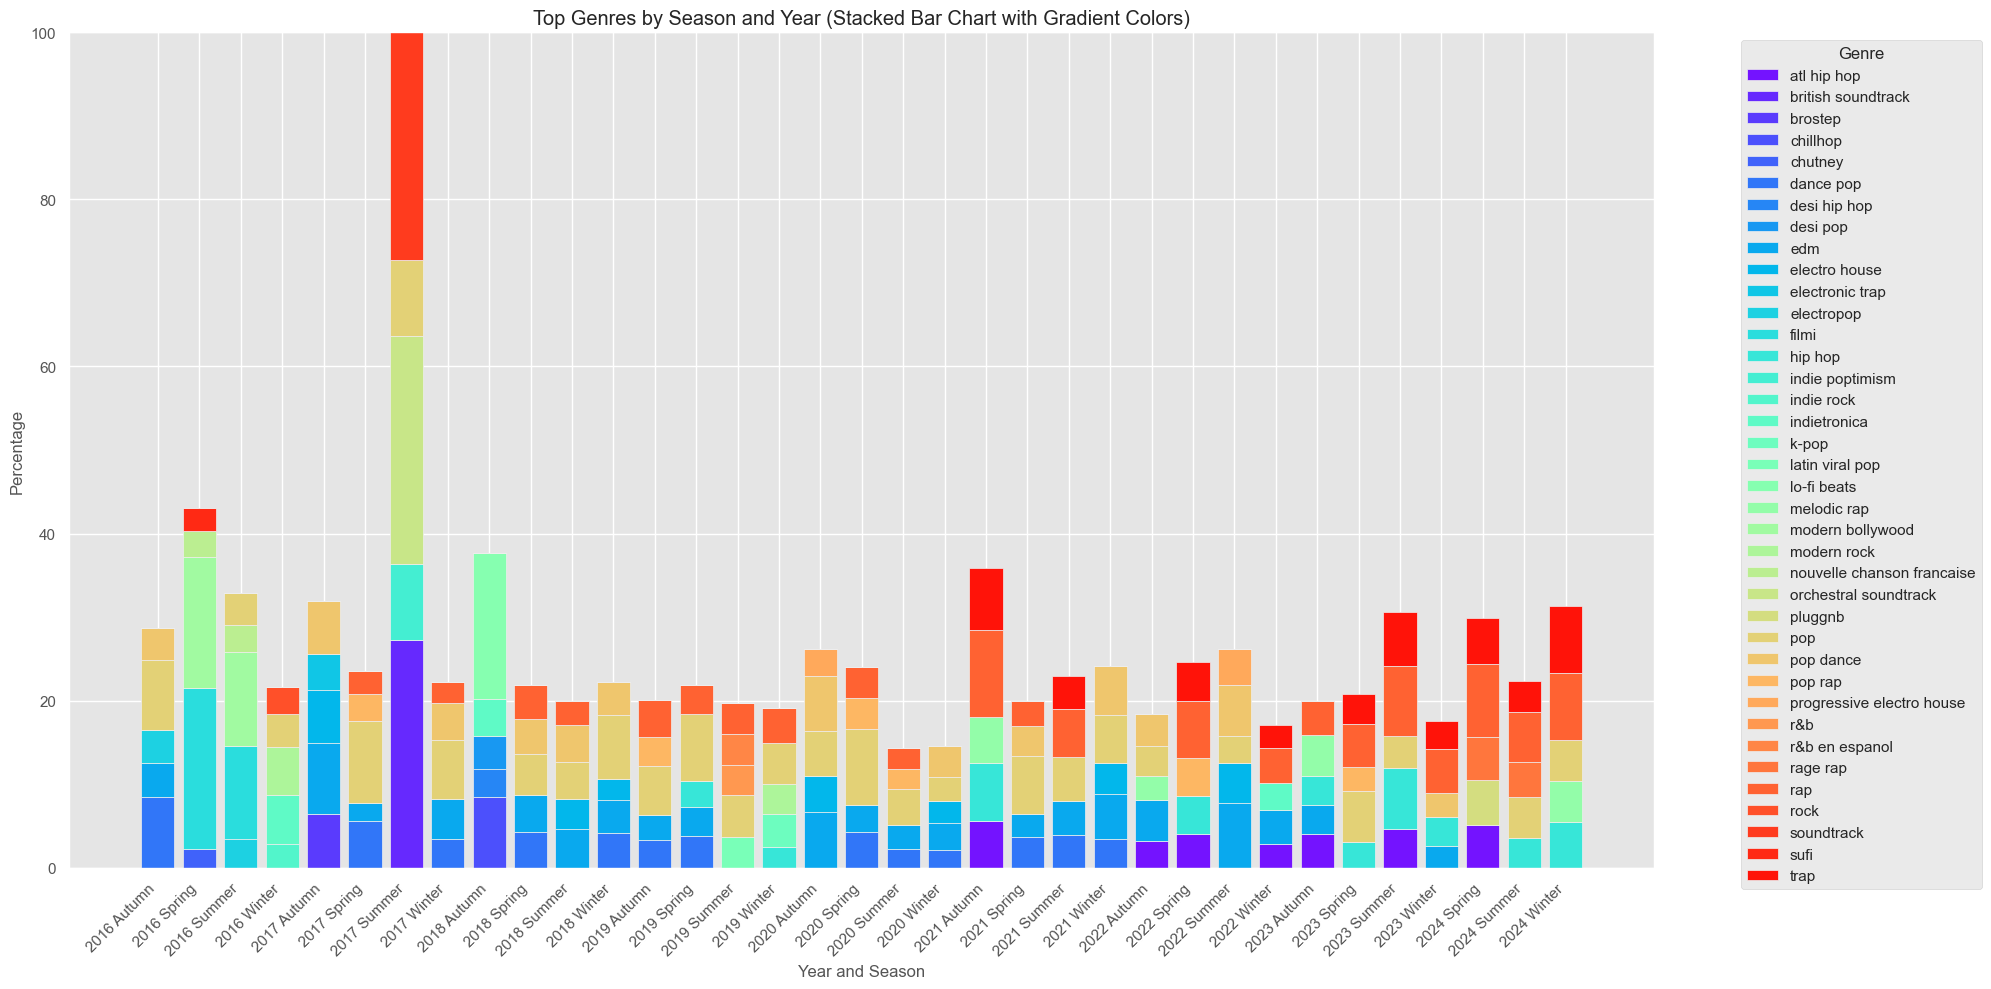

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the input DataFrame.
    """
    df_copy = df.copy()
    df_copy['Year'] = df_copy['Added At'].dt.year
    return df_copy

def explode_genres(df: pd.DataFrame) -> pd.DataFrame:
    """
    Explode the 'Genres' column into multiple rows.
    """
    return df.explode('Genres')

def calculate_genre_percentages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate genre percentages by season and year.
    """
    genre_counts = df.groupby(['Year', 'Season', 'Genres']).size().unstack(fill_value=0)
    return genre_counts.div(genre_counts.sum(axis=1), axis=0) * 100

def get_top_genres(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """
    Get the top n genres for each season and year.
    """
    return df.apply(lambda row: row.nlargest(n), axis=1).fillna(0)

def calculate_genre_percentages_by_season_year(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the top 5 genre percentages by season and year.
    """
    logging.info(f"Input DataFrame shape: {df.shape}")
    logging.info(f"Input DataFrame columns: {df.columns}")
    
    df_preprocessed = preprocess_dataframe(df)
    df_exploded = explode_genres(df_preprocessed)
    
    logging.info(f"Exploded DataFrame shape: {df_exploded.shape}")
    logging.info(f"Unique genres: {df_exploded['Genres'].unique()}")
    
    genre_percentages = calculate_genre_percentages(df_exploded)
    top_genres = get_top_genres(genre_percentages)
    
    logging.info(f"Final DataFrame shape: {top_genres.shape}")
    logging.info(f"Final DataFrame:\n{top_genres}")
    
    return top_genres

def create_color_palette(genres: List[str]) -> Dict[str, tuple]:
    """
    Create a color palette for the genres.
    """
    palette = sns.color_palette("rainbow", len(genres))
    return dict(zip(genres, palette))

def plot_stacked_bar_chart(df: pd.DataFrame, genre_colors: Dict[str, tuple]):
    """
    Plot a stacked bar chart of the genre percentages.
    """
    fig, ax = plt.subplots(figsize=(20, 10))
    bottom_values = pd.Series(0, index=df.index)
    
    for genre in df.columns[2:]:
        ax.bar(df['Year'].astype(str) + ' ' + df['Season'],
               df[genre],
               bottom=bottom_values,
               color=genre_colors[genre],
               label=genre)
        bottom_values += df[genre]
    
    ax.set_xlabel('Year and Season')
    ax.set_ylabel('Percentage')
    ax.set_title('Top Genres by Season and Year (Stacked Bar Chart with Gradient Colors)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main(df_subset: pd.DataFrame):
    """
    Main function to run the genre analysis and plotting.
    """
    genre_percentages = calculate_genre_percentages_by_season_year(df_subset)
    
    if genre_percentages.empty:
        raise ValueError("The DataFrame is empty after processing.")
    
    df_plot = genre_percentages.reset_index()
    genre_colors = create_color_palette(df_plot.columns[2:])
    plot_stacked_bar_chart(df_plot, genre_colors)

if __name__ == "__main__":
    # Assuming df_subset is already defined
    main(df_subset)

---

### I wondered, do I like current releases or nostalgic music more, and does this vary by season?

In [106]:
import pandas as pd
import numpy as np

# Create a copy of the DataFrame to avoid modifying the original data
df_copy = df_subset.copy()

# Extract year from Release Date and Added At
df_copy['Release_Year'] = df_copy['Release Date'].dt.year
df_copy['Added_Year'] = df_copy['Added At'].dt.year

# Ensure Release_Year and Added_Year are integers
df_copy['Release_Year'] = df_copy['Release_Year'].astype('Int64')
df_copy['Added_Year'] = df_copy['Added_Year'].astype('Int64')

# Calculate the gap between Added Year and Release Year
df_copy['Added_Release_YearGap'] = abs(df_copy['Added_Year'] - df_copy['Release_Year'])

# Create a table comparing Added_Year and Season
result_df = df_copy[['Track Name', 'Album Name', 'Artist Name(s)', 'Added_Year', 'Season', 'Release_Year', 'Added_Release_YearGap']].sort_values('Added_Year')

# Group by Added_Year and Season and calculate descriptive statistics for release dates compared to added date
release_stats = result_df.groupby(['Season', 'Added_Year'])['Release_Year'].agg(
    Average_Release_Year='mean',
    Median_Release_Year='median',
    Mode_Release_Year=lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan,
    Range_Release_Year=lambda x: x.max() - x.min(),
    Min_Release_Year='min',
    Max_Release_Year='max'
)

# Round the numerical values to whole numbers
release_stats = release_stats.round({
    'Average_Release_Year': 0,
    'Median_Release_Year': 0,
    'Mode_Release_Year': 0,
    'Range_Release_Year': 0,
    'Min_Release_Year': 0,
    'Max_Release_Year': 0
}).astype(int)


# Group by Added_Year and Season and calculate descriptive statistics for years between release and added dates
gap_stats = result_df.groupby(['Season', 'Added_Year'])['Added_Release_YearGap'].agg(
    Average_Gap ='mean',
    Median_Gap ='median',
    Mode_Gap =lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan,
    Range_Gap =lambda x: x.max() - x.min(),
    Min_Gap ='min',
    Max_Gap='max'
)

In [107]:
release_stats

Average_Release_Year  Median_Release_Year  \
Season Added_Year                                              
Autumn 2016                        2011                 2012   
       2017                        2016                 2016   
       2018                        2016                 2017   
       2019                        2017                 2018   
       2020                        2017                 2019   
       2021                        2019                 2021   
       2022                        2019                 2022   
       2023                        2019                 2022   
Spring 2016                        2010                 2011   
       2017                        2012                 2014   
       2018                        2016                 2017   
       2019                        2016                 2018   
       2020                        2018                 2020   
       2021                        2017                 2020   
       2022                        2021                 2022   
       2023                        2020                 2021   
       2024                        2021                 2023   
Summer 2016                        2011                 2012   
       2017                        2017                 2017   
       2018                        2016                 2018   
       2019                        2015                 2018   
       2020                        2018                 2020   
       2021                        2017                 2020   
       2022                        2018                 2021   
       2023                        2021                 2023   
       2024                        2019                 2021   
Winter 2016                        2012                 2014   
       2017                        2013                 2016   
       2018                        2015                 2017   
       2019                        2016                 2018   
       2020                        2018                 2020   
       2021                        2018                 2019   
       2022                        2019                 2020   
       2023                        2022                 2022   
       2024                        2020                 2020   

                   Mode_Release_Year  Range_Release_Year  Min_Release_Year  \
Season Added_Year                                                            
Autumn 2016                     2015                  50              1966   
       2017                     2016                   2              2015   
       2018                     2018                  13              2005   
       2019                     2019                  58              1961   
       2020                     2020                  72              1948   
       2021                     2021                  26              1995   
       2022                     2022                  57              1965   
       2023                     2022                  20              2003   
Spring 2016                     2011                  19              1997   
       2017                     2017                  52              1965   
       2018                     2018                  42              1976   
       2019                     2019                  47              1974   
       2020                     2020                  38              1982   
       2021                     2021                  60              1961   
       2022                     2022                  19              2003   
       2023                     2023                  67              1956   
       2024                     2024                  16              2008   
Summer 2016                     2013                  48              1968   
       2017                     2017                   0              2017   
       2018 

In [108]:
gap_stats

Average_Gap  Median_Gap  Mode_Gap  Range_Gap  Min_Gap  \
Season Added_Year                                                          
Autumn 2016               5.09        4.00         1         50        0   
       2017               0.75        1.00         1          2        0   
       2018               1.74        1.00         0         13        0   
       2019               2.48        1.00         0         58        0   
       2020               2.62        1.00         0         72        0   
       2021               1.68        0.00         0         26        0   
       2022               3.04        0.50         0         57        0   
       2023               4.00        1.00         1         20        0   
Spring 2016               5.90        5.00         3         19        0   
       2017               4.75        3.00         0         52        0   
       2018               2.40        1.00         0         42        0   
       2019               3.22        1.00         0         45        0   
       2020               1.76        0.00         0         38        0   
       2021               4.16        1.00         0         60        0   
       2022               1.26        0.00         0         19        0   
       2023               3.23        2.00         0         67        0   
       2024               2.76        1.00         0         16        0   
Summer 2016               5.36        4.00         3         48        0   
       2017               0.00        0.00         0          0        0   
       2018               2.37        0.00         0         59        0   
       2019               4.41        1.00         1         21        0   
       2020               1.90        0.00         0         50        0   
       2021               3.78        1.00         0         64        0   
       2022               4.16        1.00         0         61        0   
       2023               1.87        0.00         0         21        0   
       2024               5.37        3.00         3         64        0   
Winter 2016               3.53        2.00         0         51        0   
       2017               3.67        1.50         0         40        0   
       2018               3.28        1.00         0         55        0   
       2019               3.45        1.00         1         56        0   
       2020               1.79        0.00         0         60        0   
       2021               3.26        2.00         1         23        0   
       2022               3.12        2.00         1         35        0   
       2023               1.28        0.50         0         17        0   
       2024               4.46        4.00         0         24        0   

                   Max_Gap  
Season Added_Year           
Autumn 2016             50  
       2017              2  
       2018             13  
       2019             58  
       2020             72  
       2021             26  
       2022             57  
       2023             20  
Spring 2016             19  
       2017             52  
       2018             42  
       2019             45  
       2020             38  
       2021             60  
       2022             19  
       2023             67  
       2024             16  
Summer 2016             48  
       2017              0  
       2018             59  
       2019             21  
       2020             50  
       2021             64  
       2022             61  
       2023             21  
       2024             64  
Winter 2016             51  
       2017             40  
       2018             55  
       2019             56  
       2020             60  
       2021             23  
       2022             35  
       2023             17  
       2024             24

In [109]:
## Oldest song in my data
df_copy[df_copy['Release Date']==df_copy['Release Date'].min()]

,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Added At,Genres,Valence,Danceability,Energy,Tempo,Playlist,Season,Added At2,Valence_MA,Release_Year,Added_Year,Added_Release_YearGap
8229,Let It Snow! Let It Snow! Let It Snow! (with T...,Christmas Songs By Sinatra,"Frank Sinatra,B. Swanson Quartet",1948-01-01,155600,2020-11-23 01:13:35+00:00,"[adult standards, easy listening, lounge]",0.84,0.60,0.32,143.10,its_xmas,Autumn,2020-11-23 01:13:35,0.59,1948,2020,72


In [110]:
## Newest song in my data
df_copy[df_copy['Release Date']==df_copy['Release Date'].max()]

,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Added At,Genres,Valence,Danceability,Energy,Tempo,Playlist,Season,Added At2,Valence_MA,Release_Year,Added_Year,Added_Release_YearGap
150,"I Love You, Bye","I Love You, Bye","Matoma,Rufus",2024-07-26,180000,2024-07-31 19:34:49+00:00,"[pop dance, tropical house]",0.27,0.57,0.78,88.00,fs24,Summer,2024-07-31 19:34:49,0.46,2024,2024,0


/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1986152919.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




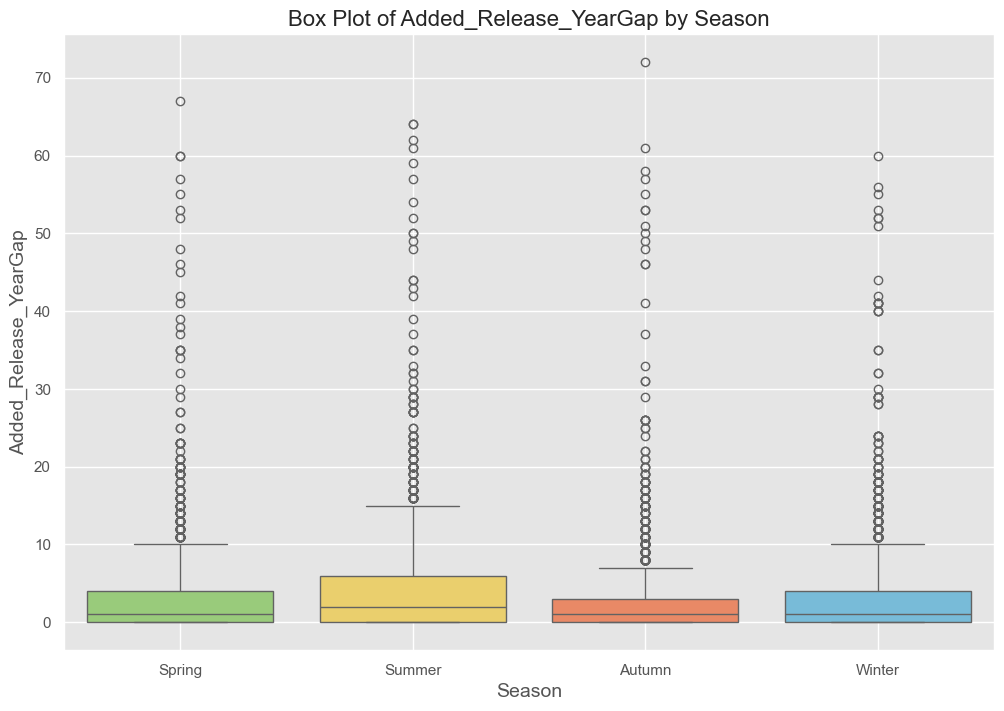

In [111]:
#Box plot for seasons and Year Added and Release Year Gap 

plt.figure(figsize=(12, 8))
sns.boxplot(x='Season', y='Added_Release_YearGap', data=df_copy, palette=season_palette)

plt.title('Box Plot of Added_Release_YearGap by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Added_Release_YearGap', fontsize=14)
plt.grid(True)


### The same broken down by year

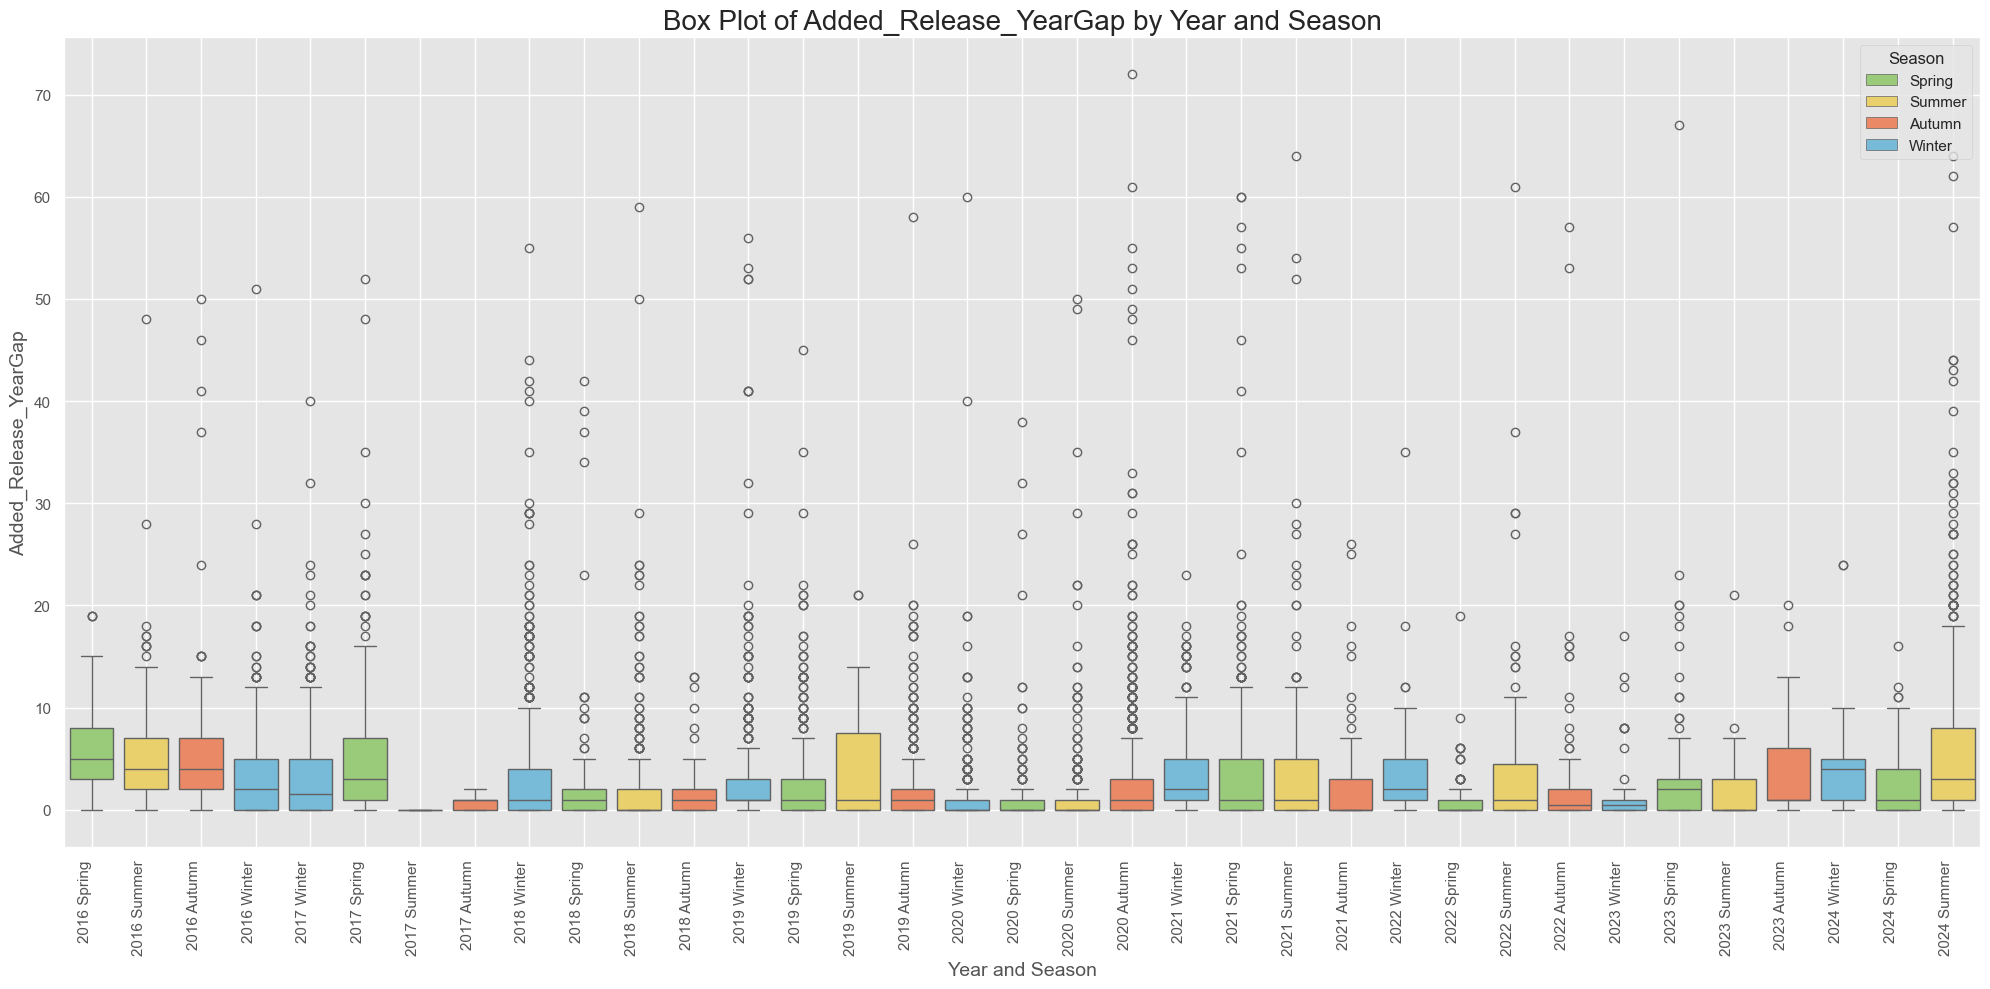

Total number of years: 9
Year range: 2016 to 2024

Median Added_Release_YearGap by Year and Season:
Season  Autumn  Spring  Summer  Winter
Year                                  
2016      4.00    5.00    4.00    2.00
2017      1.00    3.00    0.00    1.50
2018      1.00    1.00    0.00    1.00
2019      1.00    1.00    1.00    1.00
2020      1.00    0.00    0.00    0.00
2021      0.00    1.00    1.00    2.00
2022      0.50    0.00    1.00    2.00
2023      1.00    2.00    0.00    0.50
2024      <NA>    1.00    3.00    4.00


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_yearly_seasonal_boxplot(df):
    # Ensure 'Added At' is in datetime format
    df['Added At'] = pd.to_datetime(df['Added At'])
    
    # Extract year from 'Added At'
    df['Year'] = df['Added At'].dt.year
    
    # Create a new column that combines Year and Season for the x-axis
    df['Year_Season'] = df['Year'].astype(str) + ' ' + df['Season']
    
    # Define season palette
    season_palette = {'Winter': '#68c2e8', 'Spring': '#95d86e', 'Summer': '#ffdb58', 'Autumn': '#ff7f50'}   
    
    # Create a list of colors based on the season of each Year_Season combination
    colors = [season_palette[season] for season in df['Season']]
    
    # Create the plot
    plt.figure(figsize=(20, 10))
    sns.boxplot(x='Year_Season', y='Added_Release_YearGap', data=df, 
                palette=season_palette, hue='Season', dodge=False)
    
    plt.title('Box Plot of Added_Release_YearGap by Year and Season', fontsize=20)
    plt.xlabel('Year and Season', fontsize=14)
    plt.ylabel('Added_Release_YearGap', fontsize=14)
    plt.xticks(rotation=90, ha='right')
    plt.grid(True)
    
    # Modify legend
    plt.legend(title='Season', loc='upper right')
    
    plt.tight_layout()
    return plt.gcf()

def main(df):
    fig = create_yearly_seasonal_boxplot(df)
    plt.show()
    
    # Print some statistics
    print(f"Total number of years: {df['Added At'].dt.year.nunique()}")
    print(f"Year range: {df['Added At'].dt.year.min()} to {df['Added At'].dt.year.max()}")
    print("\nMedian Added_Release_YearGap by Year and Season:")
    print(df.groupby(['Year', 'Season'])['Added_Release_YearGap'].median().unstack())

if __name__ == "__main__":
    main(df_copy)

In [113]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Create a dropdown widget with the unique playlist names
playlist_dropdown = widgets.Dropdown(
    options=df_copy['Playlist'].unique(),  # Unique playlist names in the dropdown
    description='Playlist:',
    value=df_copy['Playlist'].unique()[0],  # Set the default value to the first playlist
    style={'description_width': 'initial'}
)

# Function to update the box plot based on the selected playlist
def update_boxplot(playlist_name):
    # Filter the DataFrame for the selected playlist
    df_filtered = df_copy[df_copy['Playlist'] == playlist_name]
    
    # Clear the current figure
    plt.figure(figsize=(10, 6))
    
    # Plot box plot for the selected playlist's 'Added_Release_YearGap'
    sns.boxplot(x=df_filtered['Added_Release_YearGap'], color='dodgerblue')
    
    # Set titles and labels
    plt.title(f'Box Plot of Added Year Vs. Release Year Gaps for {playlist_name}')
    plt.xlabel('Year Gap')
    
    # Show the plot
    plt.show()

# Create an interactive widget
widgets.interact(update_boxplot, playlist_name=playlist_dropdown)


interactive(children=(Dropdown(description='Playlist:', options=('54n5k4r1', 'sunday_girl_', 'o_n___t_o_p___o_…

<function __main__.update_boxplot(playlist_name)>

### What this analysis told me is that I am a nostalgic person and that the music I listen to in a playlist is, on average, older than the time it was added to the playlist with the caveat that I do add a lot of new releases to playlists because the mode release date is still (for the most part) the same as the year it was added to a playlist
_______


### Here I count unique genres and doing a pareto analysis to see what music makes up most of of my listening. I am unclear on what to glean from this for now, but it is interesting to see that nearly 50% of my music falls into just 30 genres when there are 1412 distinct ones present! 


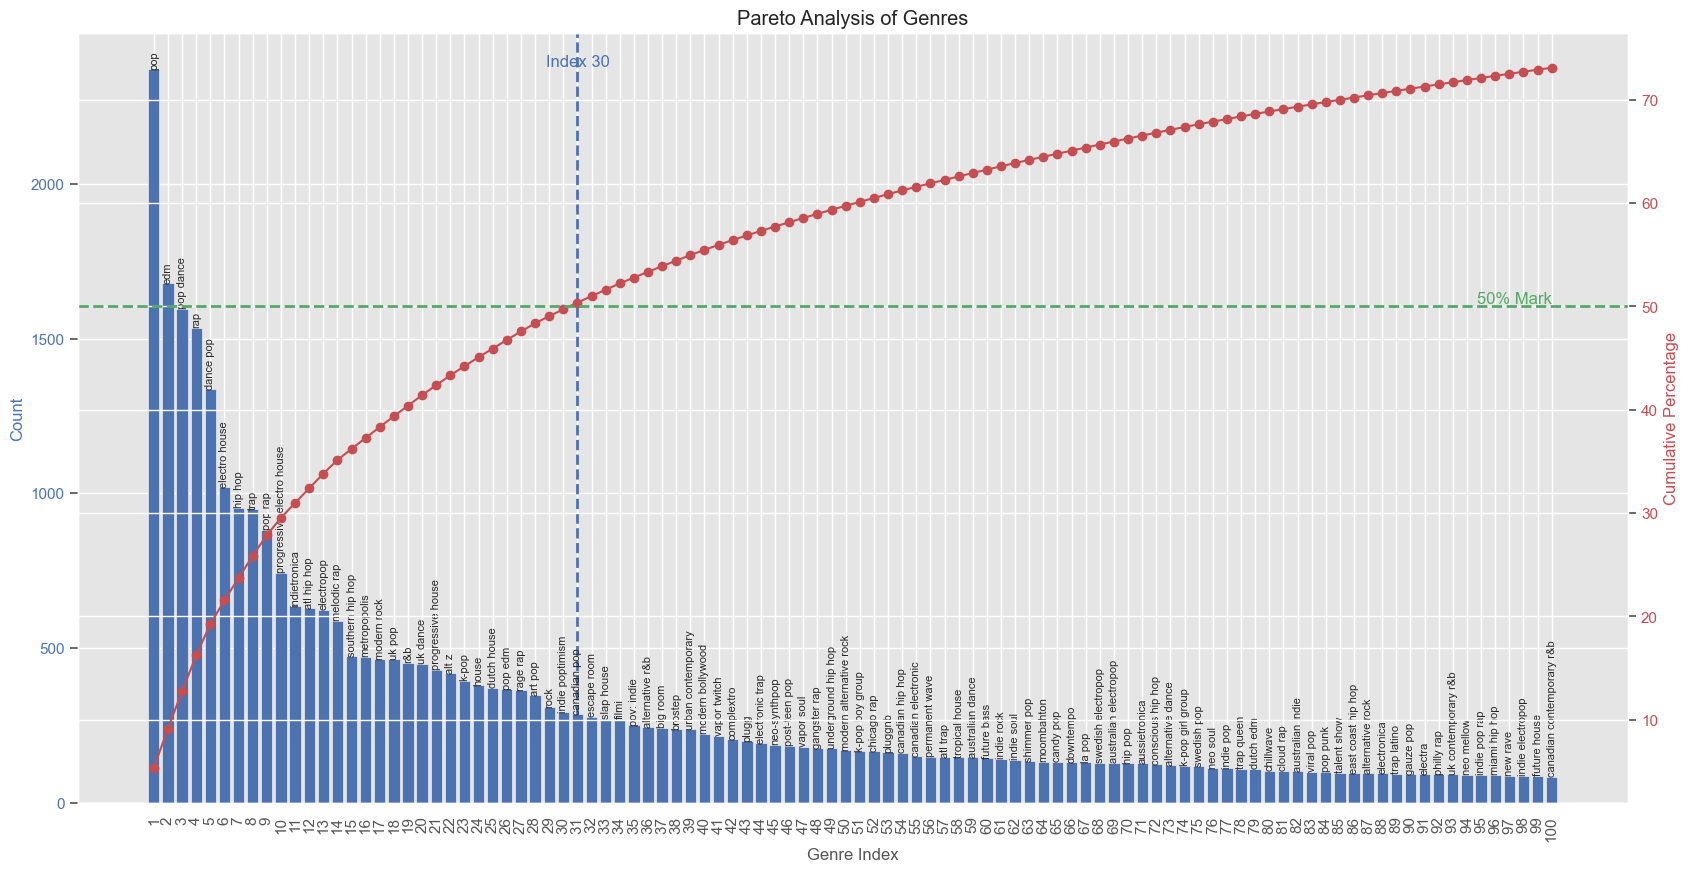

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_pareto_chart(df_subset, genres_column):
    # Explode the genres column
    exploded_df = df_subset[genres_column].explode()
    
    # Count the distinct genres
    genre_counts = exploded_df.value_counts()
    
    # Create a DataFrame for the genres
    genre_counts_df = pd.DataFrame({
        'Genre': genre_counts.index,
        'Count': genre_counts.values
    })
    
    # Calculate cumulative percentage
    genre_counts_df['Cumulative Count'] = genre_counts_df['Count'].cumsum()
    genre_counts_df['Cumulative Percentage'] = genre_counts_df['Cumulative Count'] / genre_counts_df['Count'].sum() * 100
    
    # Plot the first 100 genres
    top_100_genres = genre_counts_df.head(100)
    
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    # Bar plot for counts
    indices = range(len(top_100_genres))
    bars = ax1.bar(indices, top_100_genres['Count'], color='b')
    ax1.set_xlabel('Genre Index')
    ax1.set_ylabel('Count', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xticks(indices)
    ax1.set_xticklabels([f'{i + 1}' for i in indices], rotation=90)
    
    # Add genre names above bars vertically
    for bar, genre in zip(bars, top_100_genres['Genre']):
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval, genre, va='bottom', ha='center', rotation=90, fontsize=8)
    
    # Line plot for cumulative percentage
    ax2 = ax1.twinx()
    ax2.plot(indices, top_100_genres['Cumulative Percentage'], color='r', marker='o')
    ax2.set_ylabel('Cumulative Percentage', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Draw a horizontal line at 50% cumulative percentage
    ax2.axhline(y=50, color='g', linestyle='--', linewidth=2)
    ax2.text(len(top_100_genres) - 1, 50, '50% Mark', color='g', va='bottom', ha='right', fontsize=12)
    
    # Draw a vertical line at index 30
    ax1.axvline(x=30, color='b', linestyle='--', linewidth=2)
    ax1.text(30, top_100_genres['Count'].max(), 'Index 30', color='b', va='bottom', ha='center', fontsize=12)
    
    
    plt.title('Pareto Analysis of Genres')
    plt.show()
    
    # Return the genres table
    return genre_counts_df

# Example usage
genres = generate_pareto_chart(df_subset, 'Genres')


### Here I am using t-SNE to do clustering of genres and plotting on an interactive plot (mostly because it is cool and colorful but I can see this being useful in a later stage of my project - which is grouping songs with sentiments). I can see one cluster being all over the place (in red, cluster 1) so I am also inspired to explore that more at another time - what songs are in that genre/cluster subset? 

In [115]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px

df = genres[['Genre']]

# Convert genre names into numerical representations using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Genre'])

# Apply t-SNE to reduce the dimensionality to 2D for visualization
n_samples = df.shape[0]
perplexity = min(n_samples - 1, 30)

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
df[['tsne_x', 'tsne_y']] = tsne.fit_transform(X.toarray())

# Apply KMeans clustering to group the genres
n_clusters = min(n_samples, 10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    df,
    x='tsne_x',
    y='tsne_y',
    color='cluster',
    hover_name='Genre',
    color_continuous_scale=px.colors.qualitative.Plotly,
    labels={'cluster': 'Cluster'},
    title='t-SNE Clustering of Genres'
)

# Customize layout to make the plot larger
fig.update_layout(
    width=1000,
    height=700,
    legend_title='Cluster',
    legend=dict(
        x=1,
        y=0.5,
        traceorder='normal',
        orientation='v'
    )
)

fig.show()


/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/3247490995.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/3247490995.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### I also wanted to look at total track duration across seasons to see when I listened to longer playlists / more music by season but also by year.

#### Again, unsurprisingly, I had a lot of free time in the winter and in 2020 during the pandemic.

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/2661481360.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



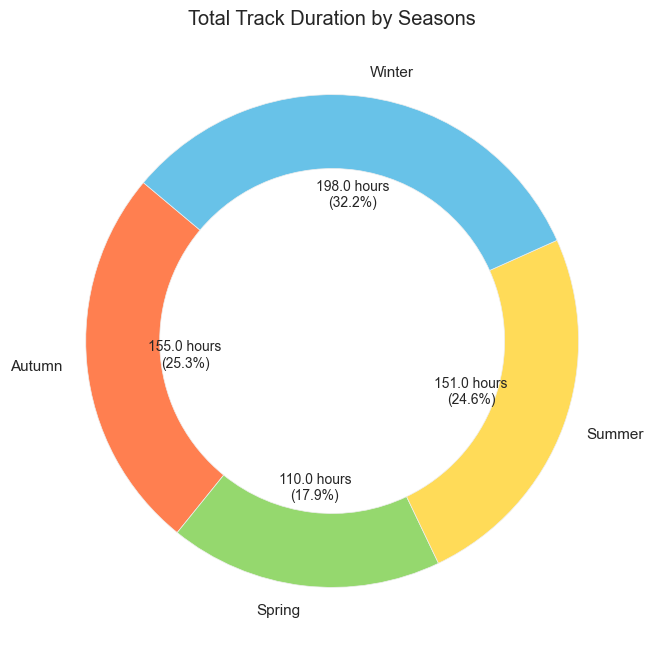

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_subset is already a DataFrame containing 'Season' and 'Duration (ms)' columns

# Convert 'Duration (ms)' to hours
df_subset['Duration (hours)'] = df_subset['Duration (ms)'] / (1000 * 60 * 60)

# Aggregate total listening time by Season
total_trackduration_by_season = df_subset.groupby('Season')['Duration (hours)'].sum().reset_index()

# Map colors to each season
colors = [season_palette.get(season, 'gray') for season in total_trackduration_by_season['Season']]

# Define a function to format the labels
def func(pct, all_values):
    absolute = int(pct / 100. * sum(all_values))
    return f'{absolute:.1f} hours\n({pct:.1f}%)'

# Create a pie chart with Matplotlib
plt.figure(figsize=(8, 8))  # Adjust figure size to be smaller
plt.pie(
    total_trackduration_by_season['Duration (hours)'],
    labels=total_trackduration_by_season['Season'],
    colors=colors,
    autopct=lambda pct: func(pct, total_trackduration_by_season['Duration (hours)']),
    startangle=140,    # Start angle of the pie chart
    wedgeprops=dict(width=0.3)  # Adjust the width of the pie chart wedges
)
plt.title('Total Track Duration by Seasons')
plt.show()

/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/1804869774.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-08-29 16:18:03,038 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-08-29 16:18:03,042 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


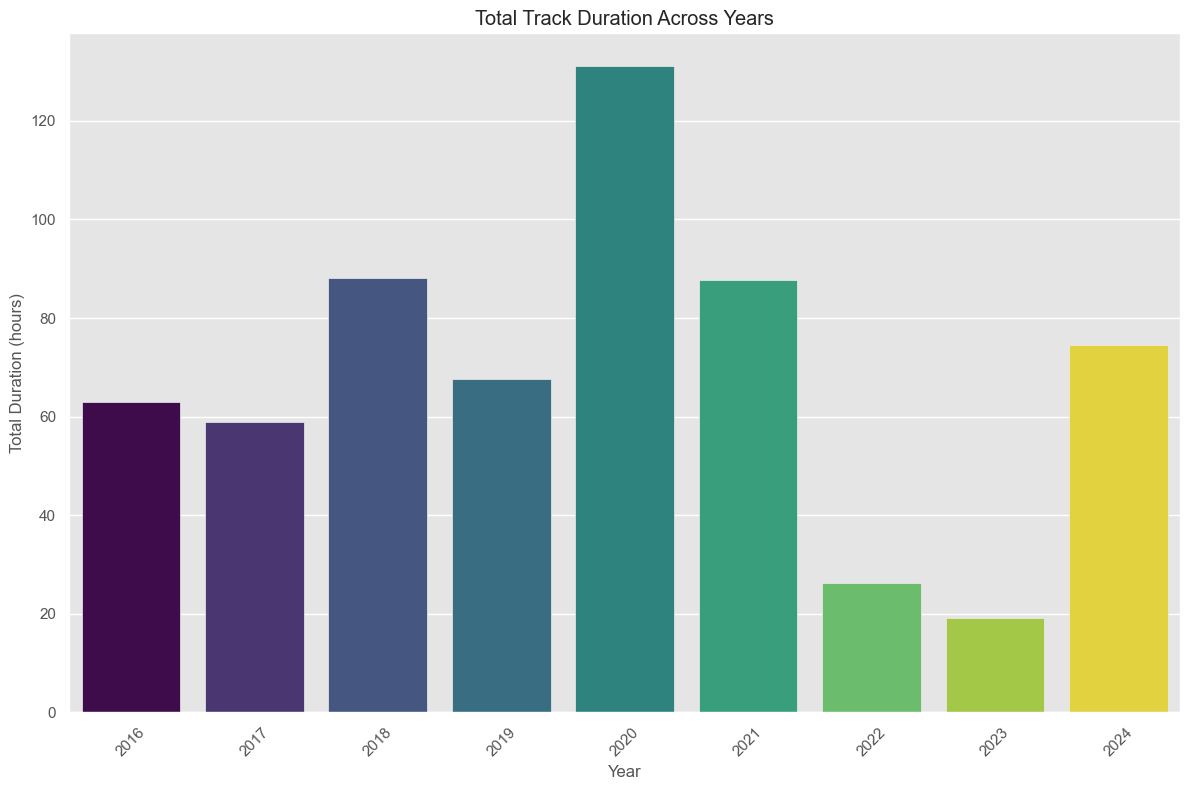

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_subset is already a DataFrame containing 'Added At' and 'Duration (ms)' columns

# Convert 'Added At' to datetime and extract the year
df_subset.loc[:, 'Added At'] = pd.to_datetime(df_subset['Added At'])
df_subset.loc[:, 'Year'] = df_subset['Added At'].dt.year

# Convert 'Duration (ms)' to hours
df_subset.loc[:, 'Duration (hours)'] = df_subset['Duration (ms)'] / (1000 * 60 * 60)

# Aggregate total listening time by Year
total_listening_time_by_year = df_subset.groupby('Year')['Duration (hours)'].sum().reset_index()

# Create a custom palette (can be modified based on year ranges)
# Example: Use a gradient or a predefined color palette for years
year_palette = sns.color_palette("viridis", as_cmap=True)

# Plot a bar plot using seaborn with custom colors
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Duration (hours)', data=total_listening_time_by_year, palette=year_palette, hue='Year', legend=False)
plt.title('Total Track Duration Across Years')
plt.xlabel('Year')
plt.ylabel('Total Duration (hours)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


### Doing a basic word cloud by track name for each season to see what the most frequently occurring words were in song titles. 

#### Upon further inspecition, the word 'Edit' only showed up as a modifier for "Radio Edit" so it seemed meaningless and I omitted it

In [118]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download nltk stopwords if not already done
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of stop words
stop_words = set(stopwords.words('english'))

# Define a function to process 'Track Name' column
def process_track_name(track_name):
    # Ensure track_name is a string
    if isinstance(track_name, str):
        # Remove text in parentheses or with "Feat."
        cleaned_name = re.sub(r'\(.*?\)', '', track_name)  # remove parentheses content
        cleaned_name = re.sub(r'Feat\..*', '', cleaned_name, flags=re.IGNORECASE)  # remove "Feat." and similar
        cleaned_name = re.sub(r'remix', '', cleaned_name, flags=re.IGNORECASE)  # remove the word "Remix"
        
        # Tokenize and convert to lowercase
        words = word_tokenize(cleaned_name.lower())
        
        # Remove stop words
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
        
        return filtered_words
    else:
        return []  # Return an empty list if track_name is not a string

# Create the new column 'Trackname_Words' safely
df_subset['Trackname_Words'] = df_subset['Track Name'].apply(process_track_name)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varshis./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/varshis./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/p_/sxdpc_pj2cq36rvp4xwys4q00000gn/T/ipykernel_14871/3906622182.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Function to create word cloud based on selected season
def create_word_cloud(season):
    """
    Generate and display a word cloud for all words in 'Trackname_Words', grouped by season.
    Exclude the word 'edit' and use darker color schemes.
    """
    # Filter data by selected season
    filtered_df = df_subset[df_subset['Season'] == season]
    
    # Flatten the list of Trackname_Words across all rows for the selected season
    all_words = [word for words_list in filtered_df['Trackname_Words'] for word in words_list]
    
    # Filter out the word 'edit' (case insensitive)
    all_words = [word for word in all_words if word.lower() != 'edit']
    
    # Count the frequency of each word
    word_freq = Counter(all_words)
    
    # Assign darker color schemes based on the season
    if season == 'Winter':
        colormap = 'Blues_r'  # Darker blue tones for Winter
    elif season == 'Spring':
        colormap = 'Greens_r'  # Darker green tones for Spring
    elif season == 'Autumn':
        colormap = 'Oranges_r'  # Darker orange to red tones for Autumn
    elif season == 'Summer':
        colormap = 'YlOrBr_r'  # Darker light orange to yellow tones for Summer

    # Create and generate a word cloud image with the chosen colormap
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(word_freq)
    
    # Clear previous output
    clear_output(wait=True)
    
    # Display the generated word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Season: {season}', fontsize=16)
    plt.show()

# Widget to select the season
season_dropdown = widgets.Dropdown(
    options=df_subset['Season'].unique(),
    description='Season:'
)

# Display the word cloud when a season is selected
widgets.interact(create_word_cloud, season=season_dropdown)


interactive(children=(Dropdown(description='Season:', options=('Spring', 'Summer', 'Autumn', 'Winter'), value=…

<function __main__.create_word_cloud(season)>